# Introduction

L'objectif de ce projet est de ségmenter le comportement des clients en fonction de leurs achats ainsi que de leurs fréquences et quantité d'achats. Ce notebook vous présentera donc l'exploration du dataset initial, avant de préparer un second dataset en vu de la ségmentation des clients. Pour une classification future des clients, un classifieur sera ensuite mis en place pour pouvoir prédire dans quel groupe un utilisateur se situe.

# Plan

<ol>
    <li>Analyse des Features
        <ul>
            <li>Gestion des invoices cancelled</li>
            <li>StockCode</li>
            <li>Description #1</li>
            <li>InvoiceDate</li>
            <li>Prix dépensé dans chaque article</li>
            <li>UnitPrice</li>
            <li>Gestion CustomerID/Country</li>
            <li>Quantity</li>
            <li>Description #2
                <ul>
                    <li>Analyse/Nettoyage des keywords</li>
                    <li>Clustering des articles par keywords</li>
                </ul>
            </li>
        </ul>
    </li>
    <li>Exploration Additionnelle
        <ul>
            <li>Panier moyen</li>
            <li>Analyse du CA</li>
        </ul>
    </li>
    <li>Modélisation
        <ul>
            <li>Création des features</li>
            <li>Clustering</li>
        </ul>
    </li>
    <li>Classifieur
        <ul>
            <li>Evaluation des modèles</li>
            <li>Fine-tuning du meilleur modèle</li>
        </ul>
    </li>
</ol>

<b>Pour des raisons de lisibilité, certaines cellules ont été commentés car n'ont été utilise que pour l'exploration mais pas pour la "lecture".</b>

In [2]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from wordcloud import WordCloud

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.manifold import Isomap, TSNE, locally_linear_embedding
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from mpl_toolkits.mplot3d import Axes3D

from sklearn.externals import joblib

%matplotlib inline

In [3]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# Analyse des Features

In [3]:
df = pd.read_excel("Online Retail.xlsx")

In [4]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.tail(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [6]:
# df.info()

In [7]:
# df.describe()

Notre dataset possède donc 542000 articles vendus sur une plage de 1 an et 1 semaine de données.
Afin d'explorer les features, un générateur a mis en place permettant d'explorer features par features les données. Pour des raisons de rendu, il a été commenté.

In [8]:
generator = (x for x in df)

In [9]:
col = next(generator)
print(col)
print(df[col].value_counts(), "\n")
print(len(df[df[col].isnull()]), "\n")
print(df[col].describe(), "\n")

InvoiceNo
573585     1114
581219      749
581492      731
580729      721
558475      705
579777      687
581217      676
537434      675
580730      662
538071      652
580367      650
580115      645
581439      635
580983      629
578344      622
538349      620
578347      606
537638      601
537237      597
536876      593
576617      593
536592      592
537823      591
576837      585
579508      578
577078      572
537240      568
577358      561
576618      552
576840      544
           ... 
569033        1
C553020       1
580987        1
C554011       1
C560574       1
569142        1
C548471       1
569135        1
546550        1
546551        1
569131        1
C543787       1
546558        1
546560        1
C544897       1
569121        1
C581128       1
569111        1
569102        1
C556904       1
C579919       1
569101        1
569099        1
569098        1
546632        1
C541651       1
569085        1
569084        1
C557890       1
C556645       1
Name: InvoiceN

### Gestion des invoice cancelled ou non

Comme expliqué dans la présentation du dataset, les ventes cancelled ont un C en 1ere lettre, on va donc créer une nouvelle feature pour gérer les annulations. Par la suite on va pouvoir re-convertir les numéros de vente en int

In [10]:
df["Cancelled"] = df["InvoiceNo"].str.startswith("C")
df["Cancelled"] = df["Cancelled"].fillna(False)

In [11]:
# df[df["Cancelled"] == True]

Comme les factures annulées ont aussi un Invoice Number unique, on peut donc convertir l'ensemble des invoices en un entier

In [12]:
df['InvoiceNo'].replace(to_replace="\D+", value=r"", regex=True, inplace=True)
df['InvoiceNo'] = df['InvoiceNo'].astype('int')

### StockCode

In [13]:
df[["StockCode", "Description"]].head(20)

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN
2,84406B,CREAM CUPID HEARTS COAT HANGER
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.
5,22752,SET 7 BABUSHKA NESTING BOXES
6,21730,GLASS STAR FROSTED T-LIGHT HOLDER
7,22633,HAND WARMER UNION JACK
8,22632,HAND WARMER RED POLKA DOT
9,84879,ASSORTED COLOUR BIRD ORNAMENT


On ne peut pas faire grand chose avec les stocks code. On remarque juste une similarité des articles en foncton de leur clé. Deux clé qui se suivent on parfois des articles très similaire à la différence de la couleur par exemple. De ce fait, on va utiliser les articles pour le classification et on peut supprimer cette feature.

In [14]:
# des codes particuliers ont été trouvé par la suite mais sont supprimés lors du nettoyage via la description 1 
# donc ils sont commentés ici

# df[df["StockCode"].str.startswith("DCGS") == True]
# df[df["StockCode"] == "BANK CHARGES"]

### Description #1

Au niveau description, on remarque que la majorité sont en Majuscule sauf certains en minuscule ou avec ???. On va donc creuser un peu

In [15]:
df["Description"].str.islower().sum()

493

On a donc 493 articles vendus qui sont en minuscules. On va donc explorer ces features

In [16]:
df[df["Description"].str.islower() == True].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
6391,536941,22734,amazon,20,2010-12-03 12:08:00,0.0,NaN,United Kingdom,False
6392,536942,22139,amazon,15,2010-12-03 12:08:00,0.0,NaN,United Kingdom,False
13217,537425,84968F,check,-20,2010-12-06 15:35:00,0.0,NaN,United Kingdom,False
13218,537426,84968E,check,-35,2010-12-06 15:36:00,0.0,NaN,United Kingdom,False
13264,537432,35833G,damages,-43,2010-12-06 16:10:00,0.0,NaN,United Kingdom,False


Si on explorer un peu plus ces features on en trouve qui commencent avec un point d'interrogation aussi. On va donc aussi les explorer.

In [17]:
df[df["Description"].str.startswith("?") == True].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
7313,537032,21275,?,-30,2010-12-03 16:50:00,0.0,NaN,United Kingdom,False
21518,538090,20956,?,-723,2010-12-09 14:48:00,0.0,NaN,United Kingdom,False
38261,539494,21479,?,752,2010-12-20 10:36:00,0.0,NaN,United Kingdom,False
43662,540100,22837,?,-106,2011-01-04 16:53:00,0.0,NaN,United Kingdom,False
50806,540558,21258,?,-29,2011-01-10 10:04:00,0.0,NaN,United Kingdom,False


On remarque qu'a chaque fois le Client est Nan. On peut donc en conclure que ce sont des frais en charge du magasin (pour remplacer des objets cassés ou d'autres frais). On va donc supprimer ces lignes:

In [18]:
df = df[df["Description"].str.startswith("?") == False]
df = df[df["Description"].str.isupper() == True]

# ajouté suite exploration par mot clé plus bas
df = df[df["Description"].str.contains("LOST") == False]

On peut maintenant regarder s'il reste des ventes faite à Nan

In [19]:
df[df["CustomerID"].isnull()][["InvoiceNo","Description"]].head(5)

,InvoiceNo,Description
1443,536544,DECORATIVE ROSE BATHROOM BOTTLE
1444,536544,DECORATIVE CATS BATHROOM BOTTLE
1445,536544,POLKADOT RAIN HAT
1446,536544,RAIN PONCHO RETROSPOT
1447,536544,VINTAGE SNAP CARDS


In [20]:
df[df["CustomerID"].isnull()].groupby("InvoiceNo")["Quantity"].count()

InvoiceNo
536544    525
536555      2
536558      1
536565      2
536592    590
536596      6
536640     11
536755     15
536756     19
536780      4
536801     14
536862     81
536864     47
536865    139
536866      1
536876    592
536883      1
536885     11
536920     10
536982    145
536991      8
537025     15
537220      1
537230      1
537237    595
537240    565
537251     20
537252      1
537253     24
537411      3
         ... 
580604      1
580605      1
580610    269
580612    253
580674      3
580683      2
580699      2
580709      2
580715      1
580724      2
580729    718
580730    659
580732      4
580739      2
580748      4
580754     72
580976      1
580983    627
581023    215
581197      8
581217    673
581219    747
581238    204
581256     62
581431      7
581435      2
581439    631
581492    728
581497     59
581498    218
Name: Quantity, Length: 1535, dtype: int64

On remarque de ce sont beaucoup des gros achats donc potentiellement fait par le magasin pour de la decoration par exemple ou pour refaire l'inventaire à cause de vols. On va donc supprimer toutes les ventes faite au magasin

In [21]:
df = df[df["CustomerID"].notnull()]

### InvoiceDate

Concernant la date des achats, on peut decouper la date par jour/moment de la journée (matin/midi/apres midi). Cela permettra  potentiellement de trouver une correlation. Par exemple on peut imaginer que les particuliers auront plus tendant à acheter en fin de journée (après le travail) ou le week-end alors que les société acheteront plus en journée.

In [22]:
df["Weekday"] = df["InvoiceDate"].dt.weekday

In [23]:
df["Weekday"]

0         2
1         2
2         2
3         2
4         2
5         2
6         2
7         2
8         2
9         2
10        2
11        2
12        2
13        2
14        2
15        2
16        2
17        2
18        2
19        2
20        2
21        2
22        2
23        2
24        2
25        2
26        2
27        2
28        2
29        2
         ..
541879    4
541880    4
541881    4
541882    4
541883    4
541884    4
541885    4
541886    4
541887    4
541888    4
541889    4
541890    4
541891    4
541892    4
541893    4
541894    4
541895    4
541896    4
541897    4
541898    4
541899    4
541900    4
541901    4
541902    4
541903    4
541904    4
541905    4
541906    4
541907    4
541908    4
Name: Weekday, Length: 404875, dtype: int64

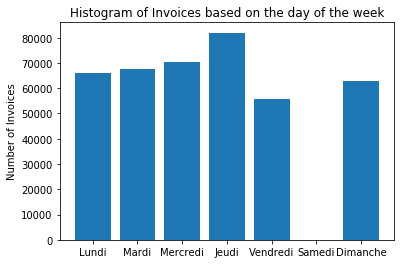

In [24]:
a = df.groupby("Weekday").agg({
    "InvoiceNo" : "count"
}).reset_index()

plt.bar(a["Weekday"].values, a["InvoiceNo"].values)
# plt.xlabel("Day of the week")
plt.ylabel("Number of Invoices")
plt.title("Histogram of Invoices based on the day of the week")
plt.xticks( list(range(7)), ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"])
plt.show()

Bizarrement, le magasin à l'air d'être fermé le samedi et ouvert le dimanche. On peut regarder les pays qui achetent le dimanche en esperant voir une correlation.

In [25]:
a = df[df["Weekday"] == 6].groupby("Country").agg({
    "InvoiceNo" : "count"
}).reset_index()
a

,Country,InvoiceNo
0,Australia,52
1,Austria,37
2,Belgium,148
3,Channel Islands,68
4,EIRE,461
5,European Community,19
6,Finland,13
7,France,646
8,Germany,797
9,Italy,12


Les achats semblent venir du monde entier donc le masin est peut-etre ouvert le dimanche... on peut maintenant regarde au niveau des heures

In [26]:
df["Time"] = df["InvoiceDate"].dt.hour

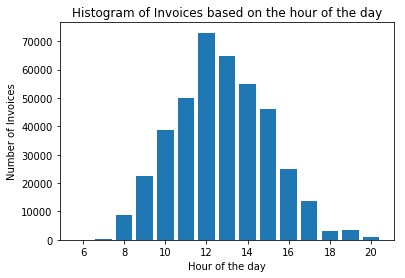

In [27]:
a = df.groupby("Time").agg({
    "InvoiceNo" : "count"
}).reset_index()

plt.bar(a["Time"].values, a["InvoiceNo"].values)
plt.xlabel("Hour of the day")
plt.ylabel("Number of Invoices")
plt.title("Histogram of Invoices based on the hour of the day")
plt.show()

On remarque donc que le magasin est un surement magasin physique comme il n'y a pas de vente entre 21het 6h du matin (bien que la présentation du dataset sur UCI dit le contraire). On peut regarder s'il y a une correlation entre les heures d'achat et le pays d'origine (notament pour les pays "loin" dU Royaume Uni)

In [28]:
a = df.groupby(["Country", "Time"]).agg({
    "InvoiceNo" : "count"
}).reset_index()
a
# plt.bar(a["Time"].values, a["InvoiceNo"].values)
# plt.xlabel("Hour of the day")
# plt.ylabel("Number of Invoices")
# plt.title("Histogram of Invoices based on the hour of the day")
# plt.show()

a[a["Country"] == "Australia"]

,Country,Time,InvoiceNo
0,Australia,8,97
1,Australia,9,188
2,Australia,10,205
3,Australia,11,101
4,Australia,12,262
5,Australia,13,207
6,Australia,14,62
7,Australia,15,137


L'australie étant en avance de 11h sur UK, on peut voir que les achats aurait lieu de nuit (de 21h à 4h du matin). De ce fait, si le magasin est en ligne, alors l'heure enregistrée est celle locale

In [29]:
def convert_to_moment(x):
    if 6 <= x <12:
        return "Morning"
    elif 12 <= x < 17:
        return "Afternoon"
    elif 17 <= x <=20:
        return "Late"

df["Time"] = df["Time"].apply(convert_to_moment)

In [30]:
df = pd.concat([df, pd.get_dummies(df['Time'])], axis=1)

In [31]:
df.drop("Time", axis=1, inplace=True)

On peut aussi en profiter pour enregister dans une feature additionnelle, l'ancienneté de l'achat

In [32]:
now = df["InvoiceDate"].max()
df["Recency"] = now-df["InvoiceDate"]
df["Recency"] = pd.to_timedelta(df["Recency"]).astype("timedelta64[D]")

### Prix dépensé dans chaque objets

Une feature additionnelle va être crée aussi pour avoir le Prix total par article. Cette feature servira a connaitre le panier total

In [33]:
df["Price"] = df["UnitPrice"] * df["Quantity"]

### UnitPrice

On peut regarder la répartion du prix des articles afin de detecter de possibles outliers

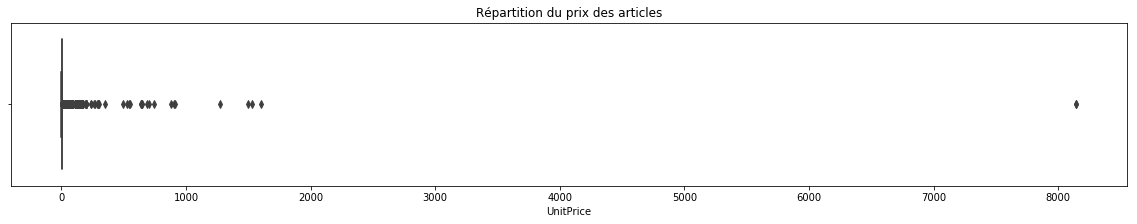

In [34]:
plt.figure(figsize=(20,3))
sns.boxplot(df["UnitPrice"])
plt.title("Répartition du prix des articles")
plt.savefig("img/price_raw.png")
plt.show()

On remarque qu'il y a quelques points dont le prix unitaire est très élevé. On peut donc regarder ce que c'est

In [35]:
df[df["UnitPrice"]>200].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,Weekday,Afternoon,Late,Morning,Recency,Price
4989,536835,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-02 18:06:00,295.0,13145.0,United Kingdom,False,3,0,1,0,371.0,295.0
32484,539080,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-16 08:41:00,295.0,16607.0,United Kingdom,False,3,0,0,1,358.0,295.0
36165,539438,22655,VINTAGE RED KITCHEN CABINET,-1,2010-12-17 15:11:00,295.0,16607.0,United Kingdom,True,4,1,0,0,356.0,-295.0
51636,540647,22655,VINTAGE RED KITCHEN CABINET,1,2011-01-10 14:57:00,295.0,17406.0,United Kingdom,False,0,1,0,0,332.0,295.0
51674,540652,22655,VINTAGE RED KITCHEN CABINET,-1,2011-01-10 15:04:00,265.5,17406.0,United Kingdom,True,0,1,0,0,332.0,-265.5


On remarque que 2 Staock Code reviennet souvent (DOT  et POST)

In [36]:
df[df["StockCode"] == "DOT"].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,Weekday,Afternoon,Late,Morning,Recency,Price
317507,564764,DOT,DOTCOM POSTAGE,1,2011-08-30 10:49:00,11.17,14096.0,United Kingdom,False,1,0,0,1,101.0,11.17
324002,565383,DOT,DOTCOM POSTAGE,1,2011-09-02 15:45:00,16.46,14096.0,United Kingdom,False,4,1,0,0,97.0,16.46
333755,566217,DOT,DOTCOM POSTAGE,1,2011-09-09 15:17:00,13.16,14096.0,United Kingdom,False,4,1,0,0,90.0,13.16
338829,566566,DOT,DOTCOM POSTAGE,1,2011-09-13 12:32:00,85.58,14096.0,United Kingdom,False,1,1,0,0,87.0,85.58
350599,567656,DOT,DOTCOM POSTAGE,1,2011-09-21 14:40:00,878.55,14096.0,United Kingdom,False,2,1,0,0,78.0,878.55


StockCode DOT représente les frais d'envoi au Royaume Uni (via DOTCOM POSTAGE) et POST concerne les envois à l'étranger. Cela se voir via la feature Country. Comme ces couts ne représente pas vraiment les ventes mais sont juste la pour compenser les frais d'envoi, on va supprimer ces lignes.

In [37]:
df = df[(df["StockCode"] != "DOT") & (df["StockCode"] != "POST")]

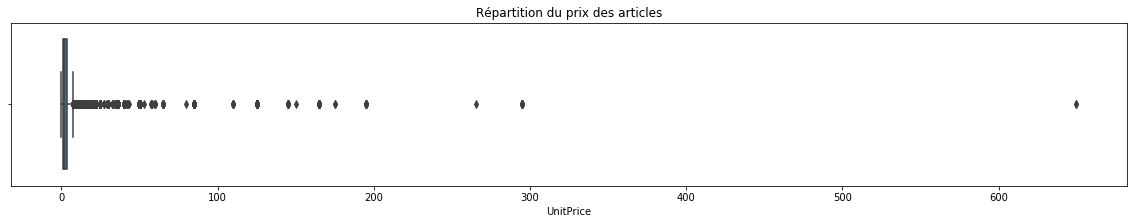

In [38]:
plt.figure(figsize=(20,3))
sns.boxplot(df["UnitPrice"])
plt.title("Répartition du prix des articles")
plt.savefig("img/price_clean.png")
plt.show()

Il reste beaucoup de points très au dessus de la moyenne. Cependant, cela correspondent vraiment à des articles couteux. De ce fait, on ne les supprime pas.

### Gestion CustomerID/Country

On peut regarder la nationalité des clients. Elle sera comparé au CA. Si 10% des clients sont étrangers mais rapportent 30% du CA, ca vaut le coup de les garder. S'ils représentent 1 % du C/A, alors ils pourront être ignorés.

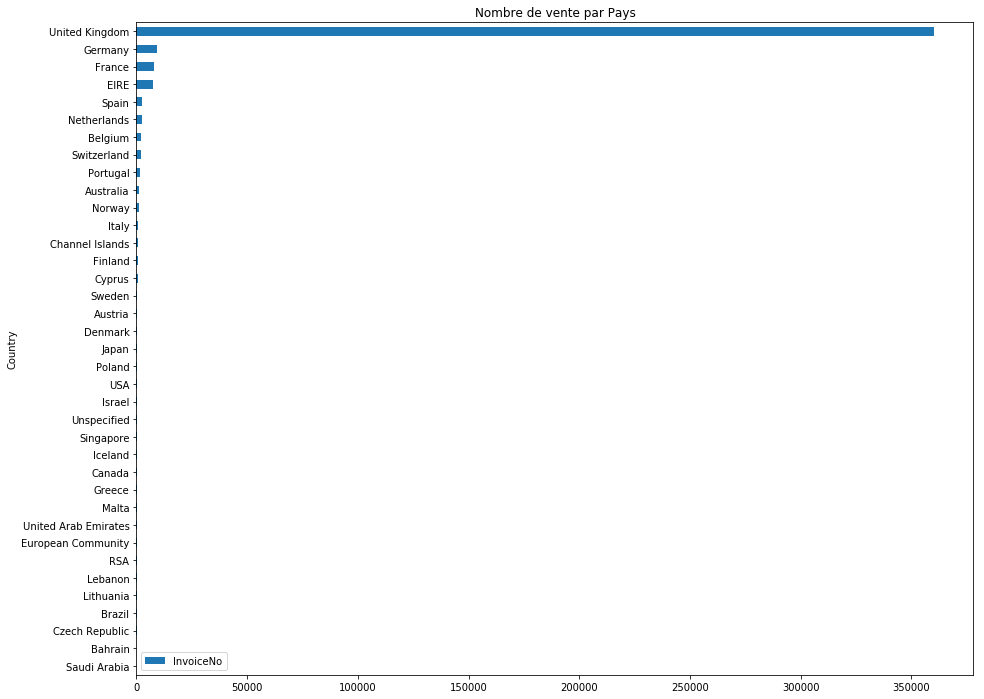

In [39]:
repartition = df.groupby("Country").agg({
    "InvoiceNo" : "count"
}).sort_values("InvoiceNo").reset_index()

repartition.set_index("Country").plot(kind='barh', figsize=(15,12))
plt.title("Nombre de vente par Pays")
plt.savefig("img/nb_vente.png")
plt.show()

In [40]:
repartition[repartition["Country"] == "United Kingdom"]["InvoiceNo"].values/repartition["InvoiceNo"].sum()

array([ 0.89183304])

89 % des ventes sont faites par des clients au Royaume Uni. Afin de savoir si l'on peut supprimer les clients hors Royaume-Uni, on peut regarder leur apport dans le CA

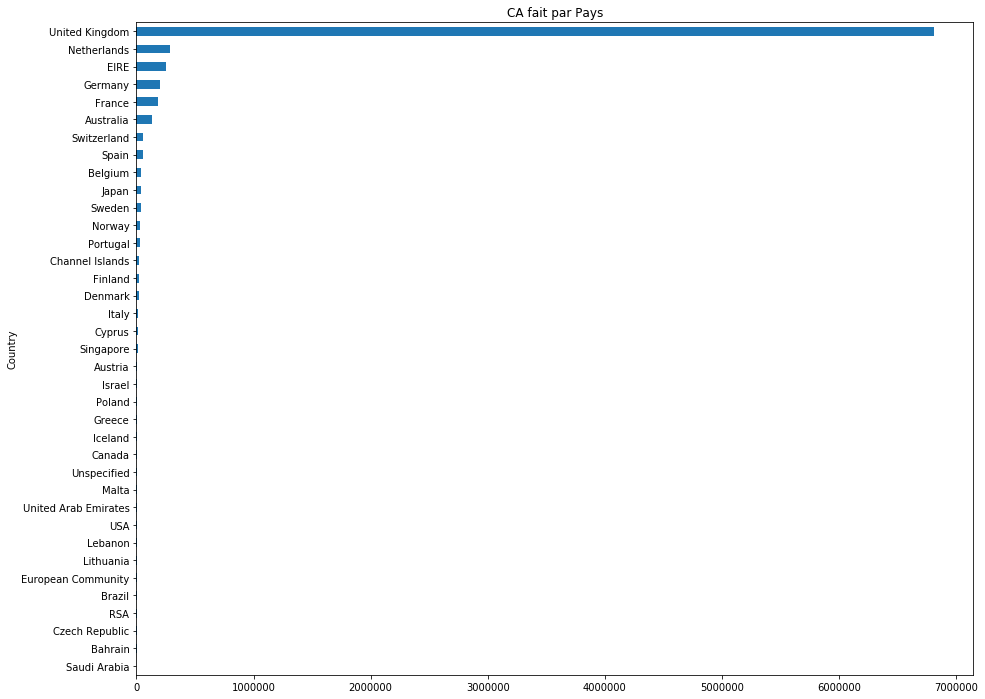

In [41]:
CA_per_countries = df.groupby(["Country"])["Price"].sum().sort_values()

CA_per_countries.plot(kind='barh', figsize=(15,12))
plt.title("CA fait par Pays")
plt.savefig("img/ca_vente.png")
plt.show()

In [42]:
CA_per_countries["United Kingdom"]/CA_per_countries.sum()

0.82263452551421146

10% des ventes sont faite à l'etranger mais représente 18 % des revenues, de ce fait on va garder la feature Country. Pour l'encoding, on va utiliser leur calssement en apport

In [43]:
# print(list(CA_per_countries.index[::-1]))

On peut maintenant encoder le dataset en fonction de leur classement et sauvegarder ce dictionnaire pour la partie production

In [44]:
decoder_countries = {i: j for i, j in enumerate(CA_per_countries.index[::-1]) }
encoder_countries = {j: i for i, j in enumerate(CA_per_countries.index[::-1]) }

df["Country"] = df["Country"].apply(lambda x:encoder_countries[x])

save_obj(decoder_countries, "decoder_countries")
save_obj(encoder_countries, "encoder_countries")

In [45]:
df[df["Cancelled"] == False]["Quantity"].describe()

count    395147.000000
mean         13.019659
std         180.876808
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

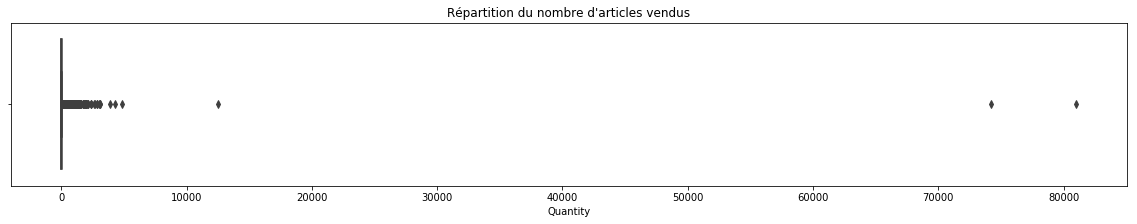

In [46]:
plt.figure(figsize=(20,3))
sns.boxplot(df[df["Cancelled"] == False]["Quantity"])
plt.title("Répartition du nombre d'articles vendus")
plt.savefig("img/qty_raw.png")
plt.show()

Comme on l'a fait avec les prix unitaire, si on regarde les achats en grosse quantité, on peut regarder si ceux l'on retrouve pour chaque vente annulé, l'achat correspondant. Comme on n'est a pas beaucoup, on peut le faire à la main

In [47]:
print(df[(df["Cancelled"] == False) & (df["Quantity"] > 2000)]["Quantity"])
print(df[(df["Cancelled"] == True) & (df["Quantity"] < -2000)]["Quantity"])

4945       2880
32671      2400
52711      3114
61619     74215
80742      2592
87631      2400
97432      3906
125282     2160
160546     3114
201149     2700
206121     4300
291249     2880
421601     2400
421632     4800
433788     3000
437480     2100
502122    12540
511421     2040
540421    80995
Name: Quantity, dtype: int64
4287      -9360
61624    -74215
160145    -3114
540422   -80995
Name: Quantity, dtype: int64


On remarque que les 2 principaux outliers ont été annulés ainsi qu'un 3eme, on peut donc les supprimer. Par contre cette méthode ne marche pas particulièrement pour les petites quantité car parfois les clients ramènent qu'une parti de leur achat.

In [48]:
qte_false = [74215, 3114, 80995]
for qte in qte_false:
    df = df[(df["Cancelled"] == False) & (df["Quantity"] !=qte)]

Si on regarde ensuite l'orfre par exemple avec 12000 articles, on peut voir que le client n'a pas ramené le produit car il n'y a pas de 2nd invoice pour cet ID de client et aucun invoice a pour quantité -12540

In [49]:
df[df["Quantity"] == 12540]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,Weekday,Afternoon,Late,Morning,Recency,Price
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256.0,0,False,4,1,0,0,13.0,0.0


In [50]:
df[df["CustomerID"] == 13256.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,Weekday,Afternoon,Late,Morning,Recency,Price
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256.0,0,False,4,1,0,0,13.0,0.0


On peut regarder maintenant le boxplot post nettoyage. On remarque qu'il y a beucoup d'outliers mais qui sont des vraies données, on doit donc les garder

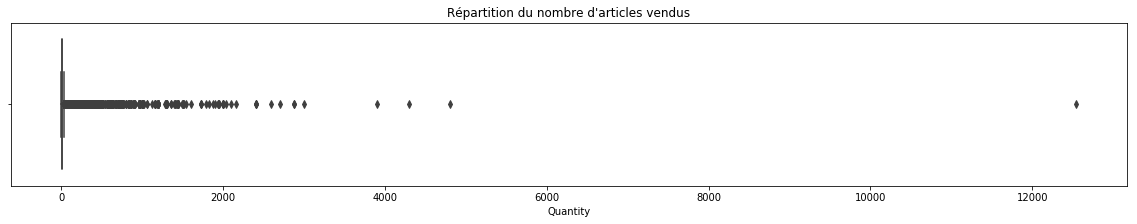

In [51]:
plt.figure(figsize=(20,3))
sns.boxplot(df[df["Cancelled"] == False]["Quantity"])
plt.title("Répartition du nombre d'articles vendus")
plt.savefig("img/qty_clean.png")
plt.show()

### Description #2

#### Analyse/Nettoyage des keywords
Les mots clés seront difficilement gérable et parfois menant sur des fausses pistes ( ex avec les couleurs). Du coup on va dans un premier temps supprimer des mots "descriptifs, avant de faire un OHE basé sur les mots de chauqe article suivi d'un clustering pour grouper les articles dans des "sacs". L'objectif étant de par exemple fusionner les articles suivants

<ul>
<li>22              RED COAT RACK PARIS FASHION</li>
<li>23           YELLOW COAT RACK PARIS FASHION</li>
<li>24             BLUE COAT RACK PARIS FASHION</li>
</ul>

<ul>
<li>3887              LETTER "F" BLING KEY RING</li>
<li>3888              LETTER "O" BLING KEY RING</li>
<li>3889              LETTER "T" BLING KEY RING</li>
<li>3890              LETTER "U" BLING KEY RING</li>
<li>3891              LETTER "W" BLING KEY RING</li>
<li>3892              LETTER "Z" BLING KEY RING</li>
</ul>

Pour cette analyse, une série de regexp va être utilisée pour supprimer certains mots/caractères.

In [52]:
df_obj = df["Description"].drop_duplicates().reset_index(drop=True).to_frame()

# On fait une colonne pour les objets nettoyés
df_obj["Keywords"] = df_obj["Description"]

Les 3 cellules suivantes ont été utilise pour determiner les regexp a utiliser. Elles sont commentés car inutiles désormais

In [53]:
# df_obj["Keywords"].drop_duplicates()

In [54]:
# keywords = df_obj["Keywords"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).sort_values(ascending=False)
# a = 0
# for index, word in keywords.iteritems():
#     print(index)

In [55]:
# df_obj[df_obj["Keywords"].str.contains(" YOU ")].drop_duplicates()

In [56]:
pat = r"RED|BLUE|PINK|BLACK|WHITE|GREEN|ROSE|SILVER|IVORY|YELLOW|LAVENDER|TURQUOISE|PURPLE|ORANGE|BROWN"  # suppression couleurs
df_obj["Keywords"] = df_obj["Keywords"].str.replace(pat, '')

In [57]:
pat = r"LARGE|MEDIUM|SMALL"  # suppresion taille
df_obj["Keywords"] = df_obj["Keywords"].str.replace(pat, '')

In [58]:
pat = r"OF|THE|IN|AND|WITH|ON|TO"  # suppresion mot fréquents inutile
df_obj["Keywords"] = df_obj["Keywords"].str.replace(pat, '')

In [59]:
df_obj["Keywords"] = df_obj["Keywords"].str.replace("CLES", "CLE")
df_obj["Keywords"] = df_obj["Keywords"].str.replace("HEARTS", "HEART")
df_obj["Keywords"] = df_obj["Keywords"].str.replace("'S", "")

In [60]:
pat = r"[a-z]+" # suppression des keywords en minuscule
df_obj["Keywords"] = df_obj["Keywords"].str.replace(pat, '')

In [61]:
pat = r"\d" # suppression des chiffres
df_obj["Keywords"] = df_obj["Keywords"].str.replace(pat, '')

In [62]:
pat = r"[,.!&/+\"]"  # suppression de caractères spécieux
df_obj["Keywords"] = df_obj["Keywords"].str.replace(pat, " ")

In [63]:
pat = r"\s[A-Z]\s"
df_obj["Keywords"] = df_obj["Keywords"].str.replace(pat, "")

In [64]:
pat = r"\s+"  # suppression des double espaces
df_obj["Keywords"] = df_obj["Keywords"].str.replace(pat, " ")

In [65]:
df_obj["Keywords"] = df_obj["Keywords"].str.strip()

On peut maintenant regarder le résultat

In [66]:
df_obj.head(10)

,Description,Keywords
0,WHITE HANGING HEART T-LIGHT HOLDER,HANGG HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN,METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER,CREAM CUPID HEART COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE,KNITTED UNI FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.,WOOLLY HOTTIE HEART
5,SET 7 BABUSHKA NESTING BOXES,SET BABUSHKA NESTG BOXES
6,GLASS STAR FROSTED T-LIGHT HOLDER,GLASS STAR FROSTED T-LIGHT HOLDER
7,HAND WARMER UNION JACK,H WARMER UNI JACK
8,HAND WARMER RED POLKA DOT,H WARMER POLKA DOT
9,ASSORTED COLOUR BIRD ORNAMENT,ASSORTED COLOUR BIRD ORNAMENT


<b>Les regexp suivantes n'ont pas été utilisées car détruisant un peu trop le sens</b>

In [67]:
# pat = r".*T-LIGHT HOLDER.*"
# df_obj = df_obj.str.replace(pat, 'T-LIGHT HOLDER')

In [68]:
# pat = r".*(NECKLACE|BAG CHARM|BRACELET|GLOVES?).*"
# df_obj = df_obj.str.replace(pat, r'\1')

# pat = r".*GLOVES?.*"
# df_obj = df_obj.str.replace(pat, r'GLOVES')

In [69]:
# pat = r".*(JUMBO|CHARLOTTE|LUNCH|SHOULDER|GIFT|SHOPPER).*BAG.*"
# df_obj = df_obj.str.replace(pat, r'\1 BAG')

In [70]:
# pat = r".*(CARDS?|MUG).*"
# df_obj = df_obj.str.replace(pat, r'\1')

In [71]:
# pat = r".*(BON BON|SWEET|JAM).*JAR.*"
# df_obj = df_obj.str.replace(pat, r'\1 JAR')

In [72]:
# pat = r".*(CAKE CASES).*"
# df_obj = df_obj.str.replace(pat, r'\1')

In [73]:
# pat = r".*(POPPY S PLAYHOUSE|BUILDG BLOCK WORD|SNACK TRAY).*"
# df_obj = df_obj.str.replace(pat, r'\1')

In [74]:
# pat = r".*(CUSHION|PASSPORT|FOOD).*COVER.*"
# df_obj = df_obj.str.replace(pat, r'\1 COVER')

# pat = r".*COVER.*(CUSHION|PASSPORT|FOOD).*"
# df_obj = df_obj.str.replace(pat, r'\1 COVER')

Ce nettoyage a été privilégié car faire un OHE sur le dataset complet aurait été très grourmand (400 000 ventes x 4000 objets). Cette méthode permet d'avoir une matrice de 4000 objets x N keywords. Dans ce cas, on va garder les mots clés qui en cumulé permet de garder 95 % des apparitions

<b>EDIT : </b> Dans un premier temps, le clustering a été fait avec les 1300 premiers mots clés. Cependant le résultat du clustering est très impacté par les principaux mots clé qui peuvent représenter tous les objets. Du coup on va en supprimer certains qui décrivent leur forme par exemple ou le type de produit

In [75]:
for word in ["SET", "HEART", "VTAGE", "BOX", "DESIGN", "FLOWER", "METAL", "RETROSPOT", "POLKADOT", "CHRISTMAS", "GLASS"]:
    df_obj["Keywords"] = df_obj["Keywords"].str.replace(word, "")

pat = r"\s+"  # suppression des double espaces
df_obj["Keywords"] = df_obj["Keywords"].str.replace(pat, " ")

df_obj["Keywords"] = df_obj["Keywords"].str.strip()

In [76]:
CS = df_obj["Keywords"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).sort_values(ascending=False).cumsum().reset_index()
CS.columns = ["keyword", "CS"]
CS.head(5)

,keyword,CS
0,BAG,157.0
1,CLE,294.0
2,HOLDER,410.0
3,HANGG,511.0
4,DECORATI,609.0


In [77]:
limite = CS['CS'].values.max()*0.95
index_max = (CS["CS"]<limite).sum()
print("95% des appartition correspondes à une somme cumulée de {} mots, cela est atteint au {}ème mot".format(limite, index_max))

95% des appartition correspondes à une somme cumulée de 11553.9 mots, cela est atteint au 1358ème mot


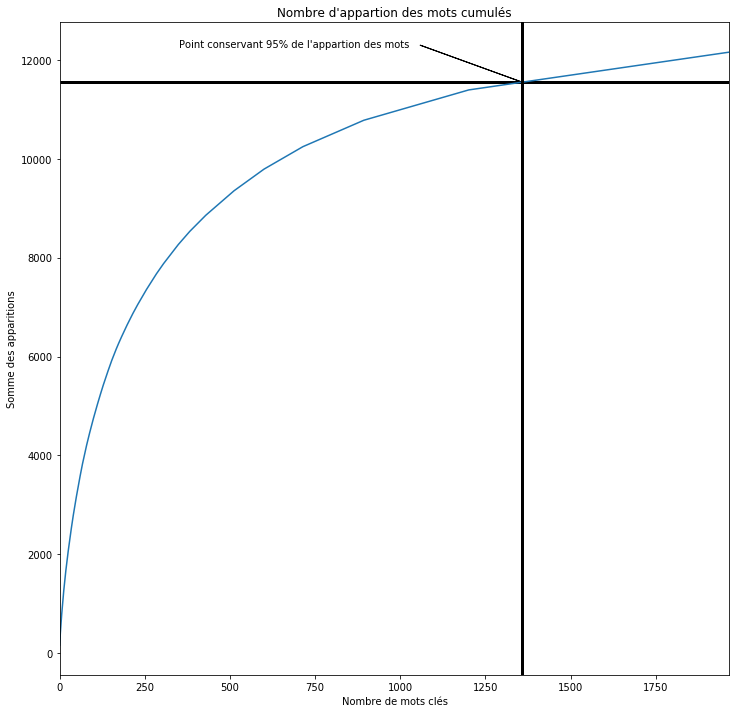

In [84]:
CS['CS'].plot(figsize=(12,12))
plt.title("Nombre d'appartion des mots cumulés")
plt.xlabel("Nombre de mots clés")
plt.ylabel("Somme des apparitions")
plt.axvline(x=index_max, linewidth=3, color='k')
plt.hlines(y=limite, xmin=0, xmax = 2000, linewidth=3, color='k')
plt.savefig("img/keyword_cs.png")
plt.annotate(xy = (350, limite+700), s="Point conservant 95% de l'appartion des mots")
plt.arrow(index_max, limite, -300, 750, hold=None)
plt.show()

On récupère donc les 1300 mots conservées

In [85]:
keywords_selected = CS["keyword"].tolist()[:index_max]

Et on fait donc un OHE sur chaque mot en fonction des mots clé

In [86]:
unique_key_obj = df_obj["Keywords"].drop_duplicates().to_frame()

In [87]:
# génération des colonnes
for key in keywords_selected:
    unique_key_obj[key] = 0

# Remplissage des lignes
for index, row in unique_key_obj.iterrows():
    for word in row["Keywords"].split(" "):
        if word in keywords_selected:
            unique_key_obj.loc[index, word] = 1  

Avec cette méthode, le clustering ne donnais pas un très bon résultat car un mot très peu utilisé peut impacté assez fortement le clustering. De ce fait, un systeme de discount a été ajouté. Plus le mot est loin dans la liste, moins il pesera (cf : discount factor en Reinforced Learning).

In [88]:
factor = 1
for col in list(unique_key_obj)[1:]:
    unique_key_obj[col] = unique_key_obj[col] * 0.99
    factor *= 0.99

In [89]:
unique_key_obj.head(5)

,Keywords,BAG,CLE,HOLDER,HANGG,DECORATI,WALL,T-LIGHT,PAPER,CAKE,...,BROCADE,TREEANGEL,TREASUREGYMKHANA,CEY,TAPER,TREASUREBUFFALO,BRZE,TAPES,WILD,CENTURY
0,HANGG T-LIGHT HOLDER,0.0,0.0,0.99,0.99,0.0,0.0,0.99,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,LANTERN,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CREAM CUPID COAT HANGER,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,KNITTED UNI FLAG HOT WATER BOTTLE,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,WOOLLY HOTTIE,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Comme notre matrice est un OHE, on n'a pas besoin de  faire de Scaling. On peut appliquer directement le Kmeans. En fonction du facteur de silhoutette on va choisir le nb de cluster pour notre modèles. 

#### Clustering des articles par keywords

In [91]:
X = unique_key_obj.drop("Keywords", axis=1)

n_cluster_opti = 0
max_silhouette = -1
for n_clusters in range(3,50):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(X)
    clusters = kmeans.predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    print("N clusters =", n_clusters, "Silhouette Score :", silhouette_avg)
    if silhouette_avg > max_silhouette:
        n_cluster_opti = n_clusters

N clusters = 3 Silhouette Score : 0.0198276697539
N clusters = 4 Silhouette Score : 0.0254665564535
N clusters = 5 Silhouette Score : 0.0290695392437
N clusters = 6 Silhouette Score : 0.0282027244206
N clusters = 7 Silhouette Score : 0.0195632165491
N clusters = 8 Silhouette Score : 0.03486170385
N clusters = 9 Silhouette Score : 0.0331479831205
N clusters = 10 Silhouette Score : 0.0327507907348
N clusters = 11 Silhouette Score : 0.0421176021249
N clusters = 12 Silhouette Score : 0.0172704093978
N clusters = 13 Silhouette Score : 0.0467255996882
N clusters = 14 Silhouette Score : 0.018132298356
N clusters = 15 Silhouette Score : 0.0334212071809
N clusters = 16 Silhouette Score : 0.0424467352921
N clusters = 17 Silhouette Score : 0.0412420986367
N clusters = 18 Silhouette Score : 0.00464746124631
N clusters = 19 Silhouette Score : 0.042936958493
N clusters = 20 Silhouette Score : 0.0331608389964
N clusters = 21 Silhouette Score : 0.0372908382475
N clusters = 22 Silhouette Score : 0.0289

En fonction des essais, on a un nombre de clusters variables. Pour la suite il a été fixé a 38 (meilleur lors d'un précédent essai)

In [92]:
kmeans = KMeans(init='k-means++', n_clusters = n_cluster_opti, n_init=30)
kmeans.fit(X)
unique_key_obj["Cluster"] = kmeans.labels_ 
X_embedded = kmeans.fit_transform(X)

On peut afficher le résultat du Kmeans en 3D

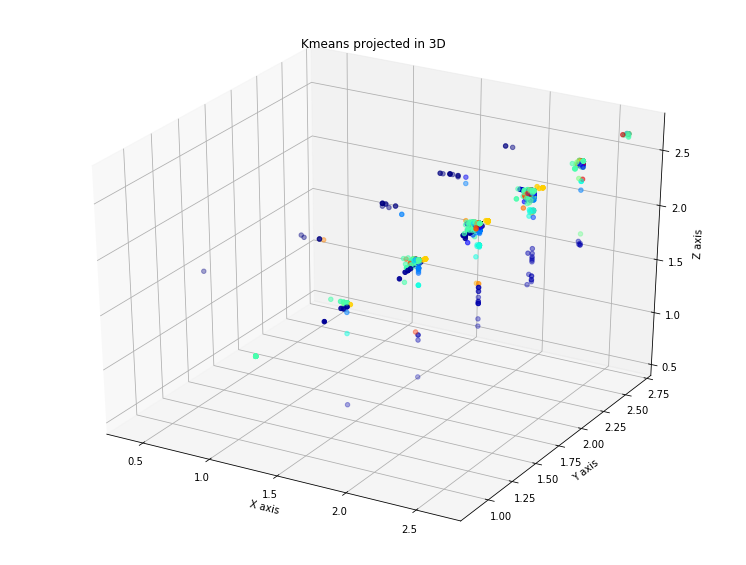

In [82]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=kmeans.labels_, cmap="jet")
plt.title("Kmeans projected in 3D")
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.savefig("img/kmeans3d_obj.png")
plt.show()

Une autre approche serait d'utiliser le TSNE pour visualiser les regroupements et les couleurs pour les labels (pour éviter de refaire le calcul à chauqe fois, l'image est mise dans une balise image)

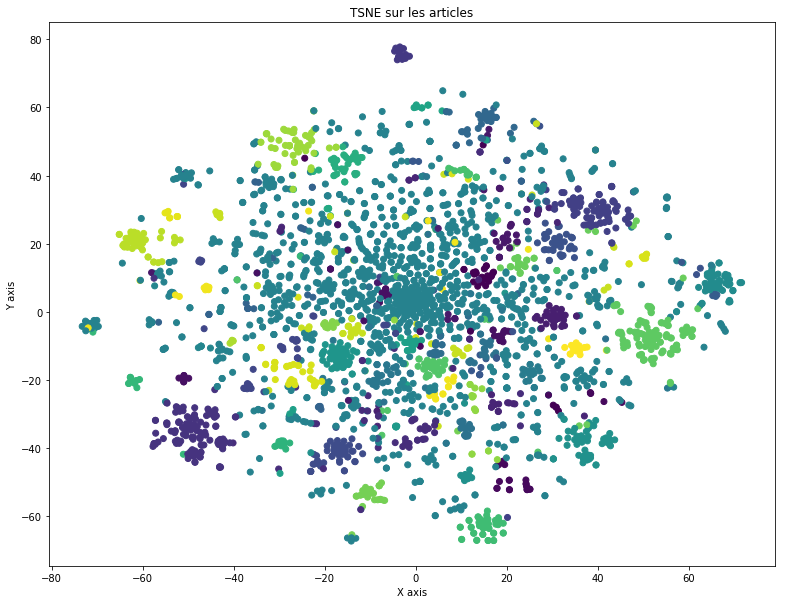

In [83]:
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(X)
color = kmeans.labels_

plt.figure(figsize=(13,10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=color)
plt.title("TSNE sur les articles")
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.savefig("img/TSNE_articles_2D_filtered.png")
plt.show()

On remarque que certains clusters sont biens regroupés. Par contre on en a un central avec les mots courants qui crée pas mal de bruits.

In [94]:
df_obj

,Description,Keywords
0,WHITE HANGING HEART T-LIGHT HOLDER,HANGG T-LIGHT HOLDER
1,WHITE METAL LANTERN,LANTERN
2,CREAM CUPID HEARTS COAT HANGER,CREAM CUPID COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE,KNITTED UNI FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.,WOOLLY HOTTIE
5,SET 7 BABUSHKA NESTING BOXES,BABUSHKA NESTG ES
6,GLASS STAR FROSTED T-LIGHT HOLDER,STAR FROSTED T-LIGHT HOLDER
7,HAND WARMER UNION JACK,H WARMER UNI JACK
8,HAND WARMER RED POLKA DOT,H WARMER POLKA DOT
9,ASSORTED COLOUR BIRD ORNAMENT,ASSORTED COLOUR BIRD ORNAMENT


On remarque une certaine similiture, par contre si on regarde par WordCloud, c'est un peu moins évident

In [ ]:
for cluster_num in [1, 12, 25]:
    text = " ".join(df_obj[df_obj["Cluster"] == cluster_num]["Keywords"].tolist())

    wordcloud = WordCloud()
    # wordcloud.generate_from_frequencies(frequencies=cnt)
    wordcloud.generate(" ".join(df_obj["Keywords"].tolist()))
    plt.figure(figsize=(12,8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Cluster {}".format(cluster_num))
#     plt.savefig("img/c{}_cloud.png".format(cluster_num))
    plt.show()

Il faut maintenant assigner les objets à leur clusters en fonction des mots clé les lables aux objets initiaux

In [95]:
df_obj = df_obj.set_index('Keywords').join(unique_key_obj[["Keywords", "Cluster"]].set_index('Keywords')).reset_index()

Maintenant que l'on a lié les objets aux clusters, on peut aussi regarder le contenu des clusters

In [97]:
df_obj[df_obj["Cluster"] == 10].head(10)

,Keywords,Description,Cluster
56,AMETHYST DROP EARRGS LEAF,SILVER/AMETHYST DROP EARRINGS LEAF,10
84,ANTIQUE MID EARRGS,ANTIQUE MID BLUE FLOWER EARRINGS,10
85,ANTIQUE OLIVE EARRGS,ANTIQUE OLIVE GREEN FLOWER EARRINGS,10
86,ANTIQUE OPAL EARRGS,ANTIQUE OPAL WHITE FLOWER EARRINGS,10
90,ANTIQUE RASPBERRY EARRGS,ANTIQUE RASPBERRY FLOWER EARRINGS,10
212,BAROQUE BUTTERFLY EARRGS,BAROQUE BUTTERFLY EARRINGS BLACK,10
213,BAROQUE BUTTERFLY EARRGS CRYSTAL,BAROQUE BUTTERFLY EARRINGS CRYSTAL,10
238,BEAD DROP EARRGS,BLACK 3 BEAD DROP EARRINGS,10
240,BEAD HOOP EARRGS,GLASS BEAD HOOP EARRINGS BLACK,10
241,BEAD HOOP EARRGS AMETHYST,GLASS BEAD HOOP EARRINGS AMETHYST,10


On sauvegarde le lien Objet -> Cluster pour une utilisation en prod

In [87]:
save_obj(df_obj.set_index("Description")["Cluster"].to_dict(), "dict_obj_cluster")

In [88]:
df_obj.to_csv("object_to_cluster.csv")

On peut aussi ajouter le cluster dataset initial via une jonction via la description

In [89]:
df = df.set_index("Description").join(df_obj[["Description", "Cluster"]].set_index('Description')).reset_index()

On a fini le nettoyage, on peut donc sauvegarder le dataset propre et passer à l'exploration

In [90]:
df = df[df["Cancelled"] == False]
df.drop(["Description", "StockCode", "InvoiceDate", "Cancelled"], axis=1, inplace=True)
df.to_csv("Online_Retail_clean.csv")

# Exploration

In [ ]:
df = pd.read_csv("Online_Retail_clean.csv", index_col=0)

### Panier moyen

On peut continuer l'exploration en regardant le panier moyen.

In [ ]:
panier_moyen = df.groupby("InvoiceNo").agg({
    "Price" : 'sum'
})

In [ ]:
panier_moyen["Price"].hist(range = (0, 1000), bins=100, figsize=(12,12))
plt.title("Répartion des Paniers moyens")
plt.xlabel("Valeur du panier")
plt.ylabel("Nombre de paniers")
plt.savefig("img/cart_hist.png")
plt.show()

On remarque un pic autour des 350 euros, on peut essayer de voir pourquoi

In [ ]:
df[(df["Price"] > 300) & (df["Price"] < 400)].head(10)

Cela semble être du au fait que certains acheteurs pros achettent en grosse quantité un certain produit (promotion ?).

### Analyse du CA

A titre informatif, on peut regarder le C/A par jour de la semaine de l'année et le moment de la journée et d'ou sont issues le CA

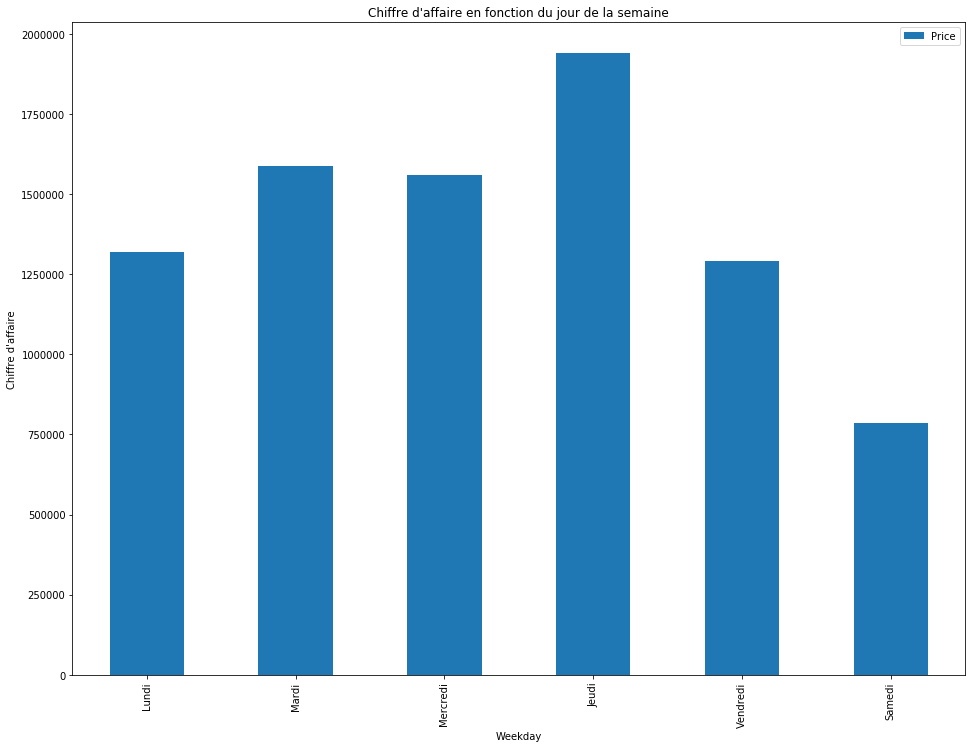

In [7]:
analyse_jour = df.groupby("Weekday").agg({
    #"InvoiceNo" : "count",
    "Price" : "sum"
})

ax = analyse_jour.plot(kind="bar", figsize=(16,12))
ax.set_xticklabels(["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi"])
plt.ylabel("Chiffre d'affaire")
plt.title("Chiffre d'affaire en fonction du jour de la semaine")
plt.savefig("img/CA_week.png")
plt.show()

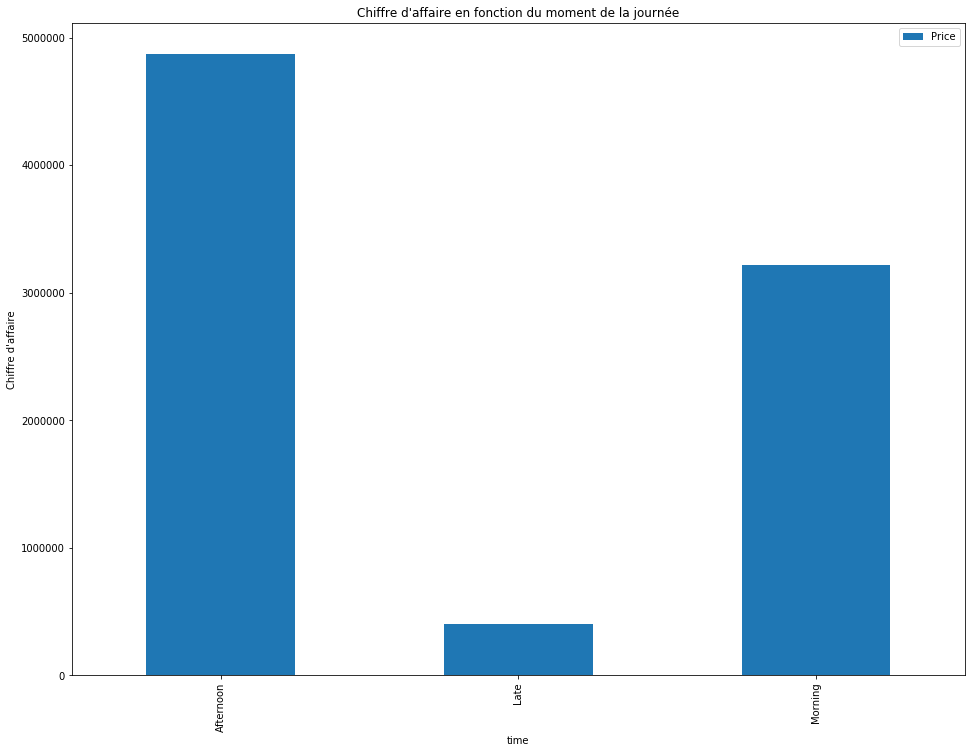

In [8]:
Cat_col = df[["Morning", "Afternoon", "Late"]].idxmax(axis=1)
s2 = pd.concat([Cat_col, df["Price"]], axis=1)
s2.columns=["time", "Price"]

analyse_time = s2.groupby("time").agg({
    "Price" : "sum"
})

analyse_time.plot(kind="bar", figsize=(16,12))
plt.ylabel("Chiffre d'affaire")
plt.title("Chiffre d'affaire en fonction du moment de la journée")
plt.savefig("img/CA_time.png")
plt.show()

Memem si les 3 buckets ne sont pas equitable en terme de durée (Morning dure 6h, afternoon dure 5 et Late dure 3h). On remarque que la grande majorité des ventes se fait l'après-midi

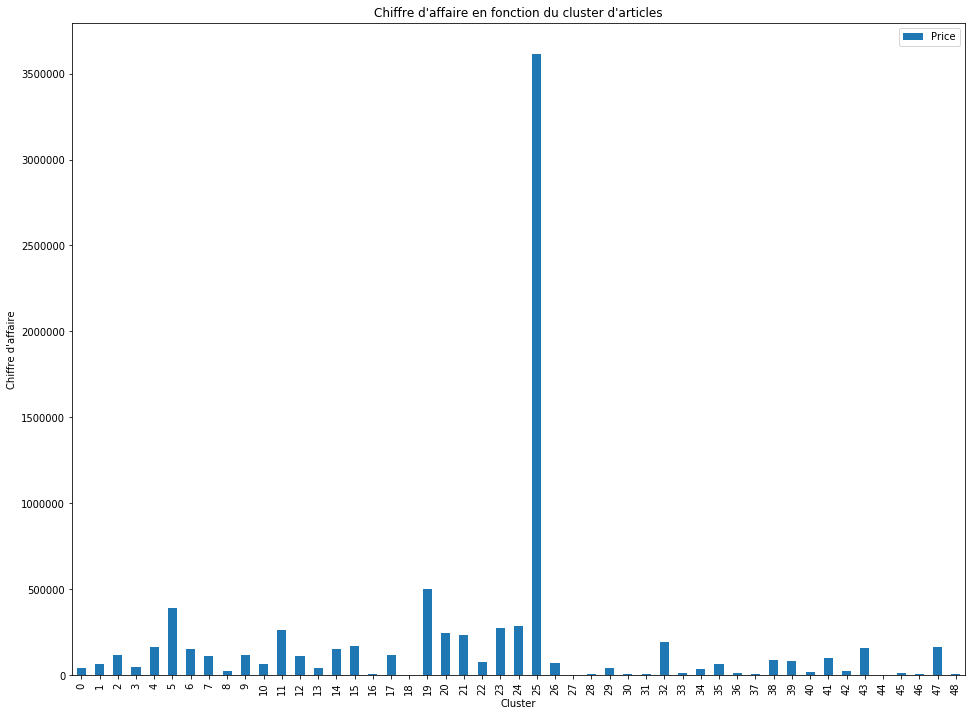

In [9]:
analyse_cluster = df.groupby("Cluster").agg({
    "Price" : "sum"
})

analyse_cluster.plot(kind="bar", figsize=(16,12))
plt.ylabel("Chiffre d'affaire")
plt.title("Chiffre d'affaire en fonction du cluster d'articles")
plt.savefig("img/CA_cluster.png")
plt.show()

In [77]:
df_obj = pd.read_csv("object_to_cluster.csv", index_col=0)
df_obj[df["Cluster"] == 25]["Description"]

C:\Anaconda501\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


286           BEWARE OF THE CAT METAL SIGN 
287                               BINGO SET
288            BICYCLE PUNCTURE REPAIR KIT 
289                 BICYCLE SAFTEY WALL ART
290                  RED RETROSPOT BIG BOWL
291      YELLOW PINK FLOWER DESIGN BIG BOWL
292             BIG DOUGHNUT FRIDGE MAGNETS
293        PINK/GREEN FLOWER DESIGN BIG MUG
294       BLUE/YELLOW FLOWER DESIGN BIG MUG
295        GREEN/BLUE FLOWER DESIGN BIG MUG
296       YELLOW/PINK FLOWER DESIGN BIG MUG
297                        BIG POLKADOT MUG
298              BILI NUT AND WOOD NECKLACE
299          VINTAGE BILLBOARD DRINK ME MUG
300         VINTAGE BILLBOARD LOVE/HATE MUG
301                  VINTAGE BILLBOARD MUG 
302               VINTAGE BILLBOARD TEA MUG
303            BIRD ON BRANCH CANVAS SCREEN
304           BIRD DECORATION RED RETROSPOT
305          BIRD DECORATION GREEN POLKADOT
306            BLACK BIRD GARDEN DESIGN MUG
307             BIRD HOUSE HOT WATER BOTTLE
308       SET OF 3 BIRD LIGHT PI

On retrouve beaucoup de produits lié à l'art (WALL ART, BIRD DECORATION, FLOWER DESIGN BIG BOWL/MUG)

On peut donc regarder leur contenu via des Word Cloud de certains cluster pour voir leur contenu. Cela peut orienter le magasin sur une facon de booster son Chiffre d'affaire.

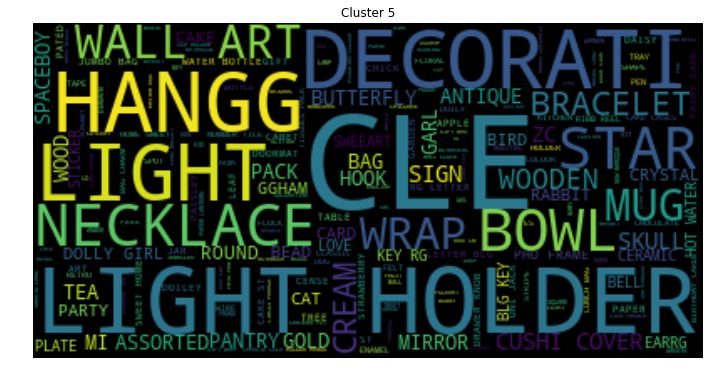

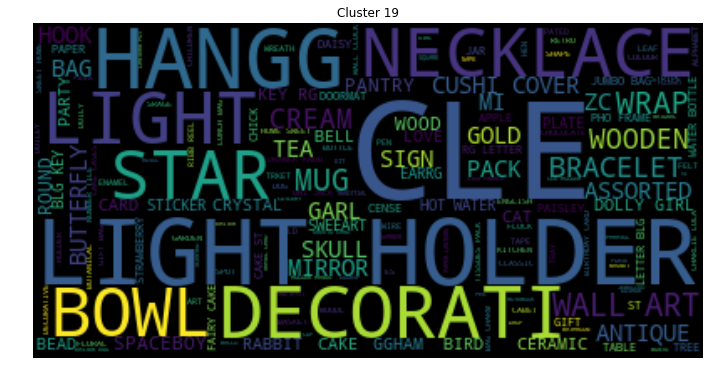

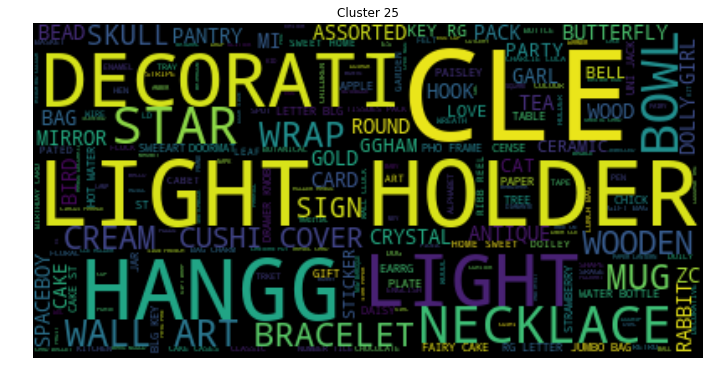

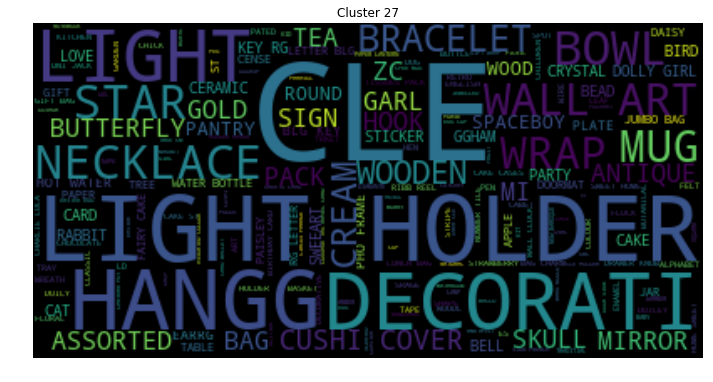

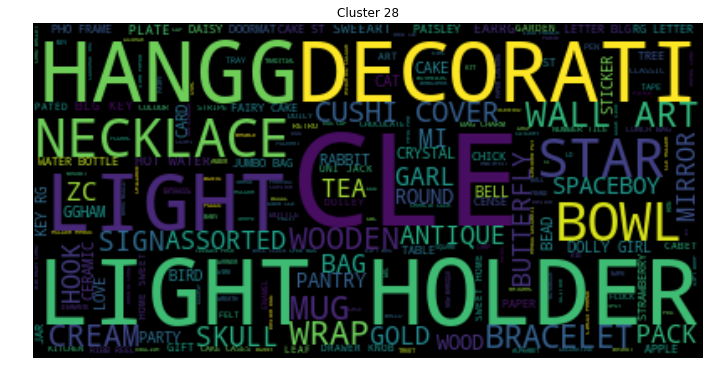

In [98]:
for cluster_num in [5, 19, 25, 27, 28]:
    text = " ".join(df_obj[df_obj["Cluster"] == cluster_num]["Keywords"].tolist())

    wordcloud = WordCloud()
    # wordcloud.generate_from_frequencies(frequencies=cnt)
    wordcloud.generate(" ".join(df_obj["Keywords"].tolist()))
    plt.figure(figsize=(12,8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Cluster {}".format(cluster_num))
    plt.savefig("img/c{}_cloud.png".format(cluster_num))
    plt.show()

On retrouve majoritairement certains mots clé (SET HEART FLOWER RETROSPOT GLASS). Il est assez difficile de trouver une tendance particulière entre les clusters. Peut-être que les mots clés principaux devrait être supprimés ??

# Modélisation

Afin d'effectuer le clustering, on va créer d'autres features. On peut notament penser à :
<ul>
<li>Panier Moyen par visite</li>
<li>Nombre d'article moyen par visite</li>
<li>Prix moyen des articles par visite</li>
<li>Durée moyenne entre les visites</li>
<li>Dernière visite</li>
<li>Nombre de visite</li>
<li>Pays</li>
<li>Prix dépensé dans chaque cluster d'article</li>
<li>Prix dépensé par jour ou moment de la journée</li>
</ul>

On doit donc préparer pour cela le dataset

In [99]:
df["nb_visits"] = 0
df["price_avg_visits"] = 0
df["recency"] = 0
df["avg_cart"] = 0
df["freq_visit"] = 0
df = pd.concat([df, pd.get_dummies(df["Cluster"], prefix="Cluster_"), pd.get_dummies(df["Weekday"], prefix="Weekday_")], axis=1)

In [100]:
df.drop(["Cluster", "Weekday"], axis=1, inplace=True)

Initiallement, je pensais partir sur la somme dépensé dans chaque cluster. mais les résutats étaient moins pertinent au final. De ce fait je suis repartie sur le nombre d'artciel acheté dans chaque catégorie

In [101]:
# for col in df:
#     if col.startswith(("Cluster", "Weekday")) or col in ["Afternoon", "Late", "Morning"]:
#         df[col] = df[col] * df["Price"]

In [102]:
#df.drop(["Price"], axis=1, inplace=True)

Dans un 1er temps on va faire un groupby invoices puis par clients.

In [104]:
custom_aggregation = {}
custom_aggregation["Price"] = "sum"
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Recency"] = lambda x:x.iloc[0]
custom_aggregation["nb_visits"] = lambda x:1
custom_aggregation["freq_visit"] = lambda x:1
for col in df:
    if col.startswith(("Cluster", "Weekday")):
        custom_aggregation[col] = "sum"
    elif col in ["Afternoon", "Late", "Morning"]:
        custom_aggregation[col] = "mean"

partial_df = df.groupby("InvoiceNo").agg(custom_aggregation)

In [105]:
custom_aggregation = {}
custom_aggregation["nb_visits"] = "count"
custom_aggregation["Quantity"] = "mean"
custom_aggregation["Recency"] = ["min", "max"]
custom_aggregation["freq_visit"] = lambda x:1
custom_aggregation["Price"] = "mean"
custom_aggregation["Country"] = lambda x:x.iloc[0]
for col in df:
    if col.startswith(("Cluster", "Weekday")) or col in ["Afternoon", "Late", "Morning"]:
        custom_aggregation[col] = "sum"
        
final_df = partial_df.groupby("CustomerID").agg(custom_aggregation)
final_df["freq_visit"] = (final_df["Recency", "max"] - final_df["Recency", "min"])/final_df["nb_visits", "count"]

On peut maintenant renommer les colonnes du dataset et sauvegardé le résultat

In [107]:
cols = [
    'nb_visits', 
    'Quantity', 
    'Recency_min', 
    'Recency_max', 
    'freq_visit', 
    'Avg_Price', 
    'Country', 
    'Afternoon', 
    'Late', 
    'Morning'
]

for i in range(49):
    cols.append("Cluster_{}".format(i))
for i in range(6):
    cols.append("Weekday_{}".format(i))
    
final_df.columns = cols

On a notre dataset pour le clustering, on peut donc le sauvegarder

In [108]:
final_df.to_csv("final_df.csv")

# Mise en place du Clustering

In [4]:
final_df = pd.read_csv("final_df.csv", index_col=0)

In [6]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4333 entries, 12347.0 to 18287.0
Data columns (total 65 columns):
nb_visits      4333 non-null int64
Quantity       4333 non-null float64
Recency_min    4333 non-null float64
Recency_max    4333 non-null float64
freq_visit     4333 non-null float64
Avg_Price      4333 non-null float64
Country        4333 non-null int64
Afternoon      4333 non-null float64
Late           4333 non-null int64
Morning        4333 non-null float64
Cluster_0      4333 non-null int64
Cluster_1      4333 non-null int64
Cluster_2      4333 non-null int64
Cluster_3      4333 non-null int64
Cluster_4      4333 non-null int64
Cluster_5      4333 non-null float64
Cluster_6      4333 non-null int64
Cluster_7      4333 non-null int64
Cluster_8      4333 non-null int64
Cluster_9      4333 non-null int64
Cluster_10     4333 non-null int64
Cluster_11     4333 non-null int64
Cluster_12     4333 non-null int64
Cluster_13     4333 non-null int64
Cluster_14     4333 non-nu

Si on regarde la plupart des features sont répartis avec une moyenne faible et un max assez élevé. De ce fait, afin de conserver la variance, lors du Clustering, on devrait utiliser le StandardScaler. Cependant, afin d'en être sur, on va faire le clustering sur avec les 2 scaling et voir lequel donne de meilleurs résultats

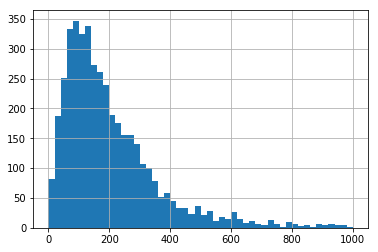

In [79]:
final_df["Quantity"].hist(bins=50, range = (0, 1000))

### Kmeans

In [102]:
y_std = []
y_minmax = []

In [103]:
scaler = StandardScaler()
X_std_scaled = scaler.fit_transform(final_df)

for n_clusters in range(3,20):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(X_std_scaled)
    clusters = kmeans.predict(X_std_scaled)
    silhouette_avg = silhouette_score(X_std_scaled, clusters)
    y_std.append(silhouette_avg)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.615324594022
For n_clusters = 4 The average silhouette_score is : 0.615332088773
For n_clusters = 5 The average silhouette_score is : 0.474266820603
For n_clusters = 6 The average silhouette_score is : 0.474296047641
For n_clusters = 7 The average silhouette_score is : 0.147199439666
For n_clusters = 8 The average silhouette_score is : 0.12725111207
For n_clusters = 9 The average silhouette_score is : 0.108873961631
For n_clusters = 10 The average silhouette_score is : 0.0701179908972
For n_clusters = 11 The average silhouette_score is : 0.0718528100789
For n_clusters = 12 The average silhouette_score is : 0.0949461799252
For n_clusters = 13 The average silhouette_score is : 0.078001775874
For n_clusters = 14 The average silhouette_score is : 0.116562174763
For n_clusters = 15 The average silhouette_score is : 0.0877851604221
For n_clusters = 16 The average silhouette_score is : 0.0888034195641
For n_clusters = 17 The average silho

In [104]:
scaler = MinMaxScaler()
X_minmax_scaled = scaler.fit_transform(final_df)

for n_clusters in range(3,20):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(X_minmax_scaled)
    clusters = kmeans.predict(X_minmax_scaled)
    silhouette_avg = silhouette_score(X_minmax_scaled, clusters)
    y_minmax.append(silhouette_avg)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.41773417305
For n_clusters = 4 The average silhouette_score is : 0.368536161011
For n_clusters = 5 The average silhouette_score is : 0.357095367159
For n_clusters = 6 The average silhouette_score is : 0.30521981089
For n_clusters = 7 The average silhouette_score is : 0.304521604464
For n_clusters = 8 The average silhouette_score is : 0.307802029627
For n_clusters = 9 The average silhouette_score is : 0.317700814812
For n_clusters = 10 The average silhouette_score is : 0.322857841534
For n_clusters = 11 The average silhouette_score is : 0.294436590661
For n_clusters = 12 The average silhouette_score is : 0.270284812992
For n_clusters = 13 The average silhouette_score is : 0.266225477041
For n_clusters = 14 The average silhouette_score is : 0.265716575445
For n_clusters = 15 The average silhouette_score is : 0.225228127221
For n_clusters = 16 The average silhouette_score is : 0.206041493854
For n_clusters = 17 The average silhouette_

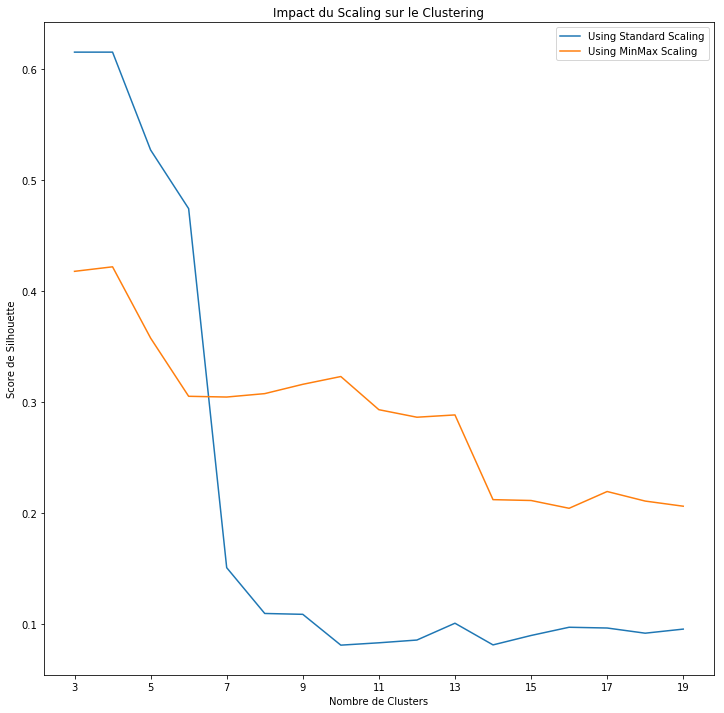

In [92]:
plt.figure(figsize=(12,12))
plt.plot(list(range(3,20)), y_std, label="Using Standard Scaling")
plt.plot(list(range(3,20)), y_minmax, label="Using MinMax Scaling")
plt.legend()
plt.xlabel("Nombre de Clusters")
plt.ylabel("Score de Silhouette")
plt.title("Impact du Scaling sur le Clustering")
plt.xticks(list(range(3,20, 2)))
plt.savefig("img/scaling.png")
plt.show()

On remarque que si l'on veut avoir un nb de cluster restreint (<7), il faut meiux utiliser le Standard Scaling. Cependant apres un essai, le scaling avec le StdScaler regroupe 90% des clients dans le meme panier et créer 5/6 clusters pour les outliers. De ce fait on va partir sur le MinMaxScaling poru le clustering

In [105]:
for n_clusters in range(3,20):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=20)
    kmeans.fit(X_minmax_scaled)
    clusters = kmeans.predict(X_minmax_scaled)
    silhouette_avg = silhouette_score(X_minmax_scaled, clusters)
    print("N clusters =", n_clusters, "Silhouette score :", silhouette_avg)

N clusters = 3 Silhouette score : 0.417811861179
N clusters = 4 Silhouette score : 0.421888282124
N clusters = 5 Silhouette score : 0.357095367159
N clusters = 6 Silhouette score : 0.305248149295
N clusters = 7 Silhouette score : 0.304547398658
N clusters = 8 Silhouette score : 0.307597722755
N clusters = 9 Silhouette score : 0.317326137594
N clusters = 10 Silhouette score : 0.323128262195
N clusters = 11 Silhouette score : 0.29347596613
N clusters = 12 Silhouette score : 0.276011959971
N clusters = 13 Silhouette score : 0.264607559202
N clusters = 14 Silhouette score : 0.263621047388
N clusters = 15 Silhouette score : 0.271601450302
N clusters = 16 Silhouette score : 0.24283227933
N clusters = 17 Silhouette score : 0.263553850269
N clusters = 18 Silhouette score : 0.206657207618
N clusters = 19 Silhouette score : 0.206524697833


Si on fait une anlyse avec beaucoup de clusters, on remarque que les meilleurs clustering sont autour de 45 clusters. Cependant, avec 45 clusters il sera difficile de visualiser la différence entre un client ou un autre selon les features. Deplus avec peu de clients, on risque d'avoir pas mal de cluster avec seulement quelques personnes. De ce faite, il faut un nombre assez restreint et 8 cluster est le plus petit cluster avec un score de silhouette assez faible. Basé sur un précédent test, je suis parti sur 9 clusters

In [108]:
kmeans = KMeans(init='k-means++', n_clusters = 9, n_init=30)
X_embedded = kmeans.fit_transform(X_minmax_scaled)
final_df["Customer_group"] = kmeans.labels_

In [116]:
final_df.to_csv("final_df_with_cluster.csv")

In [157]:
final_df = pd.read_csv("final_df_with_cluster.csv", index_col=0)

In [161]:
final_df[final_df["Customer_group"] == 7]

,nb_visits,Quantity,Recency_min,Recency_max,freq_visit,Avg_Price,Country,Afternoon,Late,Morning,...,Cluster_47,Cluster_48,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,count_cluster,Customer_group
CustomerID,,,,,,,,,,,,,,,,,,,,,
12356.0,3,524.333333,22.0,325.0,101.000000,829.143333,12,1.0,0,2.0,...,2,1,0.0,35.0,0.0,2.0,21.0,0.0,1,7
12372.0,3,262.666667,71.0,296.0,75.000000,398.680000,15,2.0,0,1.0,...,0,0,0.0,0.0,37.0,12.0,0.0,0.0,1,7
12413.0,3,94.000000,66.0,336.0,90.000000,228.700000,4,2.0,0,1.0,...,0,0,0.0,9.0,0.0,23.0,0.0,4.0,1,7
12421.0,4,119.500000,15.0,318.0,75.750000,159.760000,7,2.0,0,2.0,...,3,0,10.0,0.0,10.0,8.0,0.0,13.0,1,7
12427.0,3,175.333333,21.0,371.0,116.666667,233.266667,3,1.0,0,2.0,...,0,0,14.0,0.0,0.0,0.0,14.0,0.0,1,7
12429.0,4,384.500000,8.0,365.0,89.250000,847.100000,15,2.0,1,1.0,...,3,0,28.0,20.0,27.0,19.0,0.0,0.0,1,7
12434.0,2,197.000000,84.0,259.0,87.500000,403.070000,5,2.0,0,0.0,...,1,0,0.0,0.0,0.0,16.0,34.0,0.0,1,7
12435.0,2,1027.500000,79.0,267.0,94.000000,3914.945000,15,0.0,0,2.0,...,0,0,0.0,0.0,17.0,19.0,0.0,0.0,1,7
12458.0,2,251.000000,70.0,284.0,107.000000,393.700000,6,1.0,0,1.0,...,1,0,18.0,0.0,0.0,18.0,0.0,0.0,1,7


#### Exploration du résultat

On peut de la même manière que pour les objets, visualiser le clustering à l'aide du TSNE. D'autres modèles du groupe des manifolds ont aussi été testés mais donnent de moins bons résultats. Les codes sont donc commentés

In [102]:
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(X_std_scaled)
color = kmeans.labels_

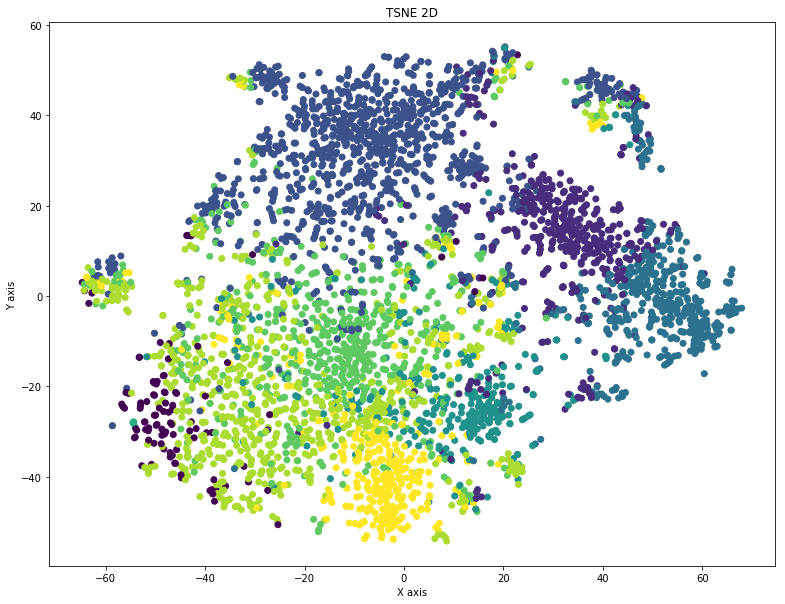

In [103]:
plt.figure(figsize=(13,10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=color)
plt.title("TSNE 2D")
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.savefig("img/TSNE_customer_2D.png")
plt.show()

In [ ]:
# iso = Isomap(n_neighbors=10, n_components=3)
# pos = iso.fit_transform(X_std_scaled)

# fig = plt.figure(figsize=(13,10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], c = color)
# ax.set_title("Isomap projected in 3D")
# ax.set_xlabel('X axis')
# ax.set_ylabel('Y axis')
# ax.set_zlabel('Z axis')
# plt.savefig("img/isomap3d.png")
# plt.show()

In [ ]:
# lle = locally_linear_embedding(X_std_scaled, n_neighbors=20, n_components=3)
# pos = lle[0]
# fig = plt.figure(figsize=(13,10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], c = color)
# ax.set_title("Isomap projected in 3D")
# ax.set_xlabel('X axis')
# ax.set_ylabel('Y axis')
# ax.set_zlabel('Z axis')
# plt.savefig("img/lle3d.png")
# plt.show()

On remarque que certains groupes packés sont groupé mais que certains clusters sont très large et sont superposés à d'autres (d'ou le score de silhouette assez faible). On peut regarder quelques valeurs en fonction du cluster ainsi que des représentations visuelles

In [8]:
def proportion(x):
    nb_abroad = x.astype(bool).sum(axis=0)
    nb_total = len(x)
    return (nb_total-nb_abroad)/nb_total

In [9]:
final_df["count_cluster"] = 1

visu = final_df.groupby("Customer_group").agg({
    "nb_visits" : "mean",
    "Quantity" : "mean",
    "Recency_max" : "mean",
    "Recency_min" : "mean",
    "freq_visit" : "mean",
    "Avg_Price" : "mean",
    "Country" : proportion,
    "Afternoon" : "sum",
    "Late" : "sum",
    "Morning" : "sum",
    "count_cluster" : "sum"
})
visu

,nb_visits,Quantity,Recency_max,Recency_min,freq_visit,Avg_Price,Country,Afternoon,Late,Morning,count_cluster
Customer_group,,,,,,,,,,,
0,4.061889,235.524954,203.833876,35.959283,48.129903,364.222766,0.892508,1519.000000,109,866.000000,614
1,1.391732,176.537376,314.586614,306.381890,3.058367,313.295549,0.885827,425.000000,26,256.000000,508
2,9.322251,242.619599,335.083120,23.762148,41.790095,412.884116,0.891304,4245.000000,320,2725.000000,782
3,3.287066,210.928109,314.719243,154.470032,53.348751,358.608678,0.933754,619.000000,50,373.000000,317
4,1.713158,253.464792,56.878070,40.372807,5.818416,381.713726,0.902632,1264.000000,100,589.000000,1140
5,1.371951,213.265633,191.050813,182.119919,3.624390,372.363148,0.916667,417.000000,42,216.000000,492
6,136.000000,417.998819,304.500000,1.000000,3.121429,1080.278136,0.750000,347.000000,55,142.000000,4
7,2.645161,197.900762,320.725806,40.943548,110.830869,332.479774,0.922043,610.000000,52,322.000000,372
8,25.875000,404.140167,352.288462,9.557692,19.871467,709.445674,0.942308,1643.181818,111,936.818182,104


In [10]:
custom_agg = {x : "mean" for x in list(final_df) if x.startswith("Cluster")}
visu2 = final_df.groupby("Customer_group").agg(custom_agg)

On a 1 Cluster presque vide dont on pourrait se passer. Le clustering étant parfois utilisé pour detecter les outliers, ce cluster les a peut-être regroupés dans 1 et ceux-ci peuvent être gérés independaments

In [111]:
final_df[final_df["Customer_group"] == 6]

,nb_visits,Quantity,Recency_min,Recency_max,freq_visit,Avg_Price,Country,Afternoon,Late,Morning,...,Cluster_47,Cluster_48,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,count_cluster,Customer_group
CustomerID,,,,,,,,,,,,,,,,,,,,,
12748.0,206,123.407767,0.0,373.0,1.810680,156.644854,0,142.0,31,33.0,...,83,3,348.0,586.0,1193.0,671.0,1066.0,706.0,1,6
14096.0,17,957.294118,3.0,101.0,5.764706,3125.884706,0,12.0,3,2.0,...,112,0,3700.0,74.0,871.0,374.0,50.0,0.0,1,6
14911.0,199,403.613065,0.0,372.0,1.869347,704.639296,2,104.0,15,80.0,...,134,3,1170.0,773.0,1041.0,1158.0,1105.0,409.0,1,6
17841.0,122,187.680328,1.0,372.0,3.040984,333.943689,0,89.0,6,27.0,...,130,28,1406.0,1525.0,1622.0,1192.0,905.0,1115.0,1,6


On remarque que ce sont des clients extremement frequents (environ 1 achat tous les 2 jours) soit un client un peu moins fréquent mais qui achete pour très cher. De ce fait, ils peuvent être géré comme des clients VIP

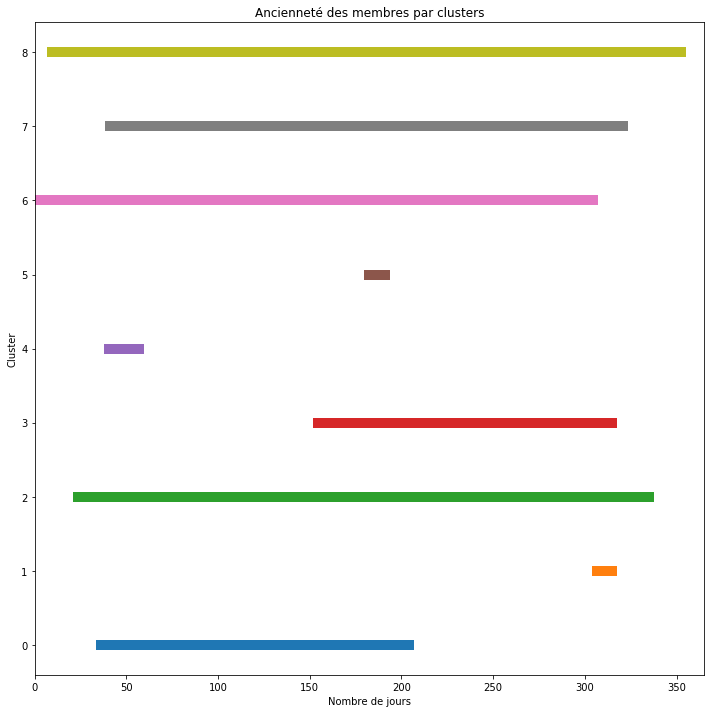

In [113]:
x_max = visu["Recency_max"].values
x_min = visu["Recency_min"].values
plt.figure(figsize = (12,12))
for i in range(9):
    plt.plot([x_min[i] , x_max[i]], [i, i], linewidth=10)
plt.xlim(0, 365)
plt.title("Ancienneté des membres par clusters")
plt.xlabel("Nombre de jours")
plt.ylabel("Cluster")
plt.savefig("img/hist_clusters.png")
plt.show()

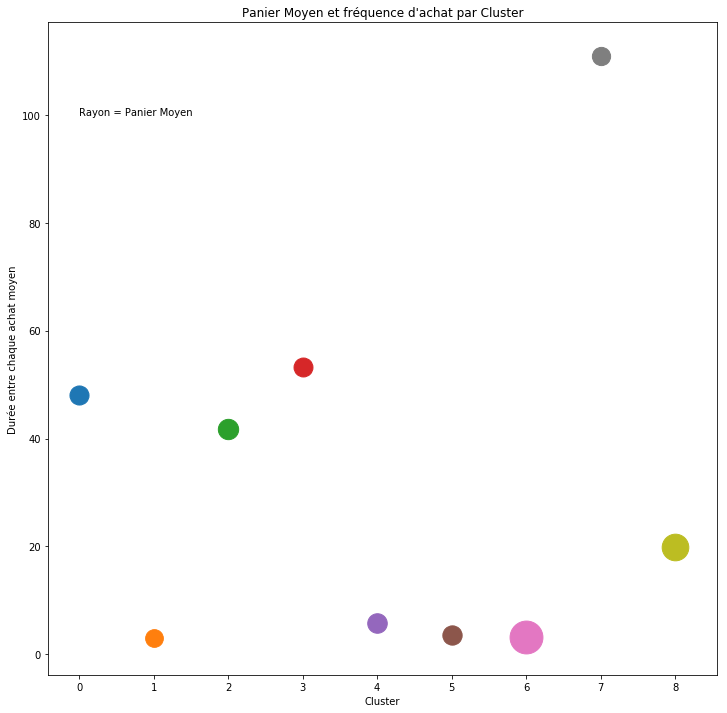

In [114]:
price = visu["Avg_Price"].values
freq = visu["freq_visit"].values
plt.figure(figsize = (12,12))
for i in range(9):
    plt.scatter(i, freq[i], s=price[i])
plt.title("Panier Moyen et fréquence d'achat par Cluster")
plt.xlabel("Cluster")
plt.ylabel("Durée entre chaque achat moyen")
plt.text(0, 100, "Rayon = Panier Moyen")
plt.savefig("img/cart_freq_clusters.png")
plt.show()

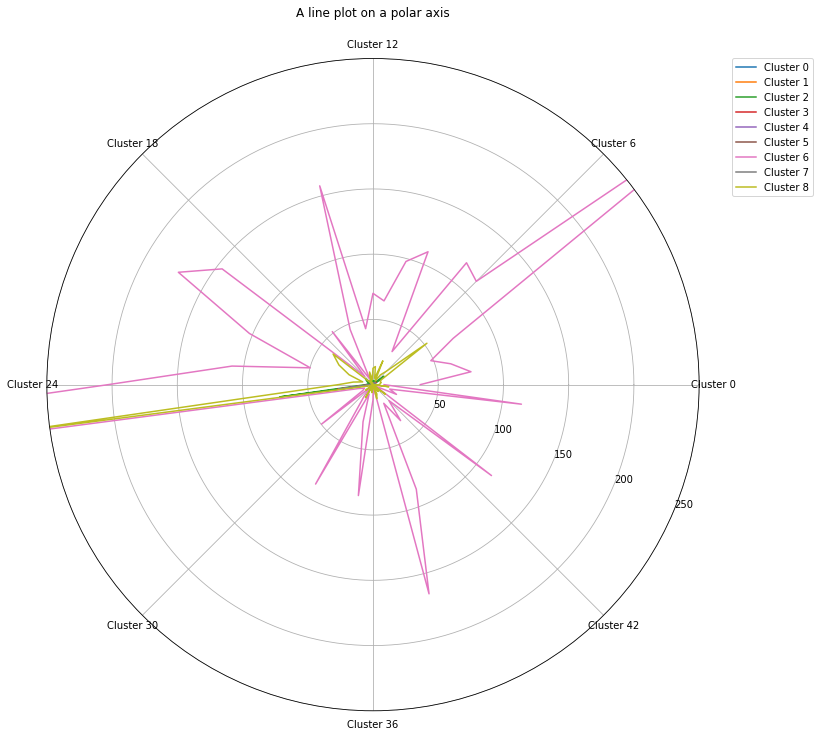

In [12]:
plt.figure(figsize=(15,12))
ax = plt.subplot(111, projection='polar')
theta = 2 * np.pi * np.linspace(0, 1, 49)
matrix = visu2.as_matrix()

for i in range(9):
    r = matrix[i, :]
    ax.plot(theta, r, label="Cluster {}".format(i))
ax.set_rmax(250)
ax.set_rmin(0)
# ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_xticklabels([
    "Cluster 0", "Cluster 6", "Cluster 12", "Cluster 18", 
    "Cluster 24", "Cluster 30", "Cluster 36", "Cluster 42"
])
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title("A line plot on a polar axis", va='bottom')
plt.savefig("img/polar_clusters.png")
plt.show()

# Classifieur

On a maintenant nos clients qui ont comme label des clusters. On peut donc mettre en place un Classifieur avec pour objectif d'avoir un modèle permettant de prédire dans quelle catégorie tombe un client en focntion de son historique d'achat sur le site

In [4]:
final_df = pd.read_csv("final_df_with_cluster.csv", index_col=0)

In [40]:
final_df[final_df["Customer_group"] == 8]

,nb_visits,Quantity,Recency_min,Recency_max,freq_visit,Avg_Price,Country,Afternoon,Late,Morning,...,Cluster_47,Cluster_48,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,count_cluster,Customer_group
CustomerID,,,,,,,,,,,,,,,,,,,,,
12415.0,20,3883.450000,23.0,337.0,15.700000,6228.226500,5,12.0,0,8.0,...,18,0,1.0,226.0,245.0,239.0,4.0,0.0,1,8
12471.0,27,300.148148,1.0,364.0,13.444444,645.335185,3,13.0,1,13.0,...,1,0,47.0,17.0,104.0,143.0,128.0,0.0,1,8
12681.0,22,338.954545,14.0,367.0,16.045455,562.070000,4,10.0,1,11.0,...,14,0,138.0,98.0,129.0,69.0,108.0,74.0,1,8
12682.0,31,177.580645,3.0,370.0,11.838710,355.749032,4,18.0,0,13.0,...,11,0,106.0,107.0,104.0,95.0,75.0,9.0,1,8
12841.0,25,110.160000,4.0,371.0,14.680000,160.642000,0,18.0,1,6.0,...,5,1,48.0,0.0,74.0,115.0,50.0,132.0,1,8
12867.0,7,612.285714,25.0,359.0,47.714286,575.968571,0,7.0,0,0.0,...,1,0,288.0,54.0,0.0,0.0,0.0,194.0,1,8
12921.0,37,257.459459,8.0,372.0,9.837838,448.299730,0,28.0,0,9.0,...,27,0,160.0,0.0,244.0,46.0,230.0,40.0,1,8
12971.0,86,108.011628,3.0,371.0,4.279070,130.115233,0,46.0,6,34.0,...,2,0,24.0,63.0,87.0,74.0,39.0,18.0,1,8
13018.0,28,194.107143,15.0,295.0,10.000000,259.917857,0,17.0,0,11.0,...,6,0,58.0,49.0,86.0,101.0,75.0,89.0,1,8


On retire le Cluster d'outlier

In [14]:
final_df = final_df[final_df["Customer_group"] != 6]

In [15]:
X = final_df.drop(["count_cluster", "Customer_group"], axis=1)
y = final_df["Customer_group"] 

On va donc recomparer les 2 scalers pour évaluser les modèles avec de fine-tune le meilleur. Pares essai, les 2 Scaler fonctionnent aussi bien sur le meilleur modèle Random Forest. La grosse différence se fait sur le KNN et SVC qui ont des perfs très différentes

In [16]:
scaler = StandardScaler()
X_std_scaled = scaler.fit_transform(X)
scaler2 = MinMaxScaler()
X_minmax_scaled = scaler2.fit_transform(X)

On va donc sauvegarder le meilleur Scaler

In [17]:
joblib.dump(scaler2, 'prod/scaler.pkl') 

['scaler.pkl']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_minmax_scaled, y, test_size=0.15, random_state=42)
# X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_std_scaled, y, test_size=0.15, random_state=42)

## KNN

Pour le KNN, on va l'évaluer en regardant par rapport au nombre de voisins aussi

In [19]:
for voisin in range(1,12):
    neigh = KNeighborsClassifier(n_neighbors=voisin)
    neigh.fit(X_train, y_train) 
    print("Nb voisins :", voisin, " - Score :", neigh.score(X_test, y_test))

Nb voisins : 1  - Score : 0.890769230769
Nb voisins : 2  - Score : 0.883076923077
Nb voisins : 3  - Score : 0.926153846154
Nb voisins : 4  - Score : 0.906153846154
Nb voisins : 5  - Score : 0.921538461538
Nb voisins : 6  - Score : 0.926153846154
Nb voisins : 7  - Score : 0.936923076923
Nb voisins : 8  - Score : 0.926153846154
Nb voisins : 9  - Score : 0.936923076923
Nb voisins : 10  - Score : 0.930769230769
Nb voisins : 11  - Score : 0.936923076923


## SVC

In [20]:
clf = SVC()
clf.fit(X_train, y_train) 
print(clf.score(X_test, y_test))

0.836923076923


## Naive Bayes

In [21]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print(gnb.score(X_test, y_test))

0.463076923077


## Decision Tree

Comme on a un nombre de données limité, le decision tree va être testé avec certains level de profondeur mais resteint pour ne pas overfitter le dataset

In [22]:
for max_depth in range(3, 10):
    clf = DecisionTreeClassifier(random_state=0, max_depth=max_depth)
    clf.fit(X_train, y_train)
    print(max_depth, clf.score(X_test, y_test))

3 0.681538461538
4 0.869230769231
5 0.924615384615
6 0.94
7 0.94
8 0.935384615385
9 0.94


L'interet avec Random Forest est de pouvoir visualiser les features de décision

In [23]:
from sklearn.tree import export_graphviz

export_graphviz(clf, "graph.dot")

# dans une invite cdm : dot -Tpng graph.dot -o graph.png

Le graph est trop grand pour être affiché mais il est disponible dans le repository github

## Random Forest

On peut de la même manière regarder si le Random Forest fonctionne e mieux que le Random Tree

In [24]:
for max_depth in range(3, 20):
    clf = RandomForestClassifier(random_state=0, max_depth=max_depth, n_estimators=100)
    clf.fit(X_train, y_train)
    print(max_depth, clf.score(X_test, y_test))

3 0.783076923077
4 0.863076923077
5 0.9
6 0.918461538462
7 0.929230769231
8 0.946153846154
9 0.941538461538
10 0.941538461538
11 0.944615384615
12 0.953846153846
13 0.953846153846
14 0.952307692308
15 0.950769230769
16 0.953846153846
17 0.952307692308
18 0.956923076923
19 0.955384615385


Le modèle le plus performant est donc le Random Forest. On va donc le fine Tune

# Fine Tuning

Pour éviter tout overfitting, le training du gridSearch va se faire avec CrossValidation

In [25]:
parameters = {
    'n_estimators':[5, 10, 20, 30, 50],   # on va rester en rbf 
    'max_features': [None, "sqrt", "log2"],
    'max_depth' : [3, 5, 10, 12, 15],
    'min_samples_leaf' : [1, 2, 3, 5]
}
RFC = RandomForestClassifier()
clf = GridSearchCV(RFC, parameters, cv=3, scoring="accuracy")
clf.fit(X_minmax_scaled, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 20, 30, 50], 'max_features': [None, 'sqrt', 'log2'], 'max_depth': [3, 5, 10, 12, 15], 'min_samples_leaf': [1, 2, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

On peut maintenant afficher le résultat et sauvegarder le meilleur modèle

In [26]:
cvres = clf.cv_results_
for acc, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(acc, params)
print("\n", clf.best_params_)

0.811734811735 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 5}
0.778701778702 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 10}
0.761607761608 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 20}
0.796257796258 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 30}
0.812196812197 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 50}
0.75975975976 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 5}
0.796026796027 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 10}
0.810348810349 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 20}
0.811734811735 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 30}
0.797412797413 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 50}
0.725802725803 {'max_depth': 3, '

In [27]:
joblib.dump(clf.best_estimator_ , 'prod/final_model.pkl') 

['final_model.pkl']

On a maintenant les meilleurs paramètres, on peut donc re-découper le dataset en train/test et l'evaluer de cette manière. On peut ainsi afficher la confusion Matrix, calculer la précision, le recall et l'accuracy.

In [28]:
def plot_confusion_matrix(cm, classes=None,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if classes is not None:
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("img/confusion.png")

Confusion matrix, without normalization
[[ 95   0   2   0   1   0   0   0]
 [  0  75   0   1   0   0   0   0]
 [  3   0 114   0   0   0   1   3]
 [  0   1   2  32   0   0   1   0]
 [  1   0   0   0 157   0   0   0]
 [  0   0   0   0   0  76   0   0]
 [  1   0   1   1   0   0  61   0]
 [  0   0   4   0   0   0   0  17]]


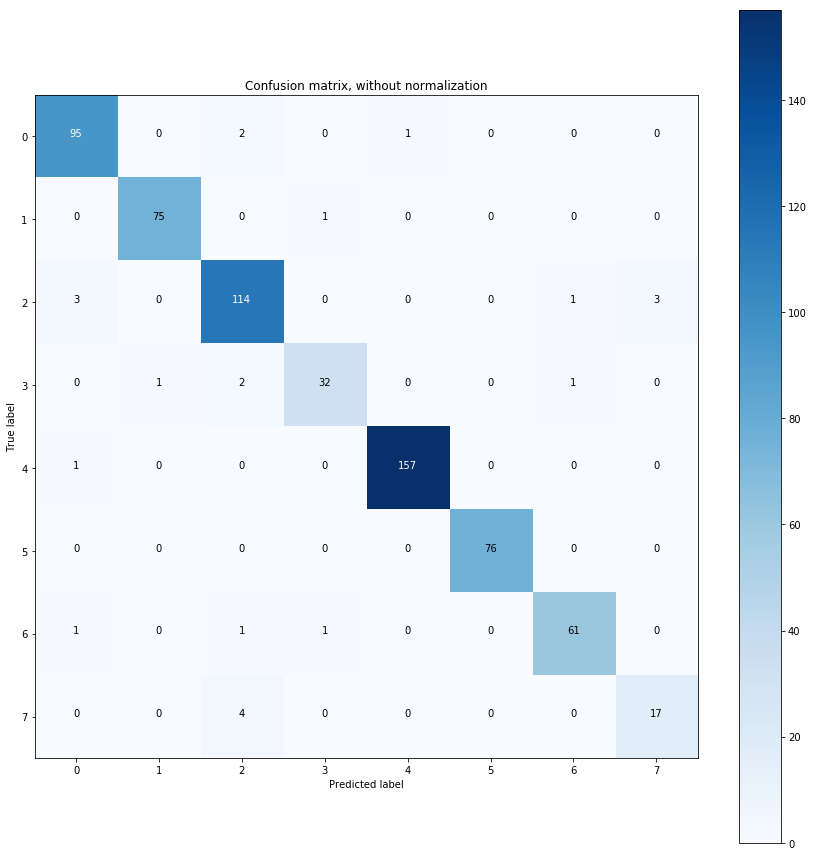

In [29]:
final_estimator = clf.best_estimator_ 

final_estimator.fit(X_train, y_train)
y_pred = final_estimator.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure(figsize = (12,12))
plot_confusion_matrix(cnf_matrix, title='Confusion matrix, without normalization')
plt.savefig("img/confusion.png")
plt.show()

In [30]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [31]:
print("Accuracy : ", accuracy_score(y_test, y_pred))
print("Recall : ", recall_score(y_test, y_pred, average="macro"))
print("Precision : ", precision_score(y_test, y_pred, average="macro"))

Accuracy :  0.964615384615
Recall :  0.942948400648
Precision :  0.952096587309


# Conclusion

Durant ce projet, nous avons vu comment segmenter les clients en fonction de leurs habitudes d'achats (articles et données temporelles). Un classifieur a ensuite été mis en place afin d'evaluer le plus rapidement possible dans quel cluster un client va tomber.  